# A comparison of Rural Towns in the Netherlands

## IBM Data science certificate - Capstone Project

Laura Bongaardt, Delft, The Netherlands

The objectives are:

1. Identify and locate Rural Towns of interest, based on Population Size and Distance to a city.
2. Make a comparison of Rural Towns, relative to cities and other towns, based on Population Growth and Average Income.
3. Determine which Rural Towns are successfull and which are less successfull.
4. Identify industries that are commonly present in successfull Rural Towns.

In [1]:
#General libraries, almost always required
import pandas as pd
import numpy as np

In [ ]:
#Libraries for scraping and importing
import requests
import json
#Beautifulsoup
from bs4 import BeautifulSoup as bs4

In [2]:
#Libraries for plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

I'm using IBM db2 to store backups of my tables. This also allows me to reload a table and continue after restarting a session.

In [3]:
#Libraries for connection with database
import ibm_db
import ibm_db_dbi
from sqlalchemy import create_engine

Entering credentials. This cell will be hidden in final,public, notebook

In [4]:
# The code was removed by Watson Studio for sharing.

In [5]:
#create engine as connection object
engine = create_engine('ibm_db_sa://'+ dsn_uid + ':' + dsn_pwd + '@'+dsn_hostname+':'+dsn_port+'/' + dsn_database )

# Part 1: Identify and locate Rural Towns

## 1.1: Collect data from sources
I have to start by collecting the required data from various sources. I'm using two tables from the Central Bureau of Statistics (CBS), information from the postal service (postcode.site) and adding geolocations using geopy library.

### 1.1.1: Table 84992NED: List of registered places and municipalities.
I start by requesting table 84992NED from the CBS, which contains a table of all registred places in the Netherlands, their municipality and their region (called province). The municipality is important, because not all place names are unique, but the combination with their municipality is.

In [2]:
response = requests.get("https://opendata.cbs.nl/ODataApi/OData/84992NED")
print(response.status_code, " 200=successful")

200  200=successful


In [3]:
response.json()

{'odata.metadata': 'https://opendata.cbs.nl/ODataApi/OData/84992NED/$metadata',
 'value': [{'name': 'TableInfos',
   'url': 'https://opendata.cbs.nl/ODataApi/OData/84992NED/TableInfos'},
  {'name': 'UntypedDataSet',
   'url': 'https://opendata.cbs.nl/ODataApi/OData/84992NED/UntypedDataSet'},
  {'name': 'TypedDataSet',
   'url': 'https://opendata.cbs.nl/ODataApi/OData/84992NED/TypedDataSet'},
  {'name': 'DataProperties',
   'url': 'https://opendata.cbs.nl/ODataApi/OData/84992NED/DataProperties'},
  {'name': 'CategoryGroups',
   'url': 'https://opendata.cbs.nl/ODataApi/OData/84992NED/CategoryGroups'},
  {'name': 'Woonplaatsen',
   'url': 'https://opendata.cbs.nl/ODataApi/OData/84992NED/Woonplaatsen'}]}

So the API actually leads to multiple tables designated by multiple API's. I want *TypedDataSet* and *Woonplaatsen*. The contents of which will be merged in a new dataframe. I start by requesting *TypedDataSet* and filter the contents using a loop.

In [4]:
response = requests.get("https://opendata.cbs.nl/ODataApi/OData/84992NED/TypedDataSet").json()
rjson_list = response.get('value')

In [5]:
data=[]
for rps in rjson_list:  
    data.append({
        "Place_code": rps.get('Woonplaatsen').strip(),
        "Municipality": rps.get('Naam_2').strip(),
        "Municipality_code": rps.get('Code_3').strip(),
        "Province": rps.get('Naam_4').strip(),
        "Province_code": rps.get('Code_5').strip(),
    })
df_1 = pd.DataFrame(data)
df_1.head()

,Place_code,Municipality,Municipality_code,Province,Province_code
0,WP1925,Almelo,GM0141,Overijssel,PV23
1,WP2774,Veere,GM0717,Zeeland,PV29
2,WP2145,Coevorden,GM0109,Drenthe,PV22
3,WP2571,Aalsmeer,GM0358,Noord-Holland,PV27
4,WP1600,Haarlemmermeer,GM0394,Noord-Holland,PV27


I now have the first part, with Municipalities and place codes. The table *Woonplaatsen* also contains place codes and the actual names of the places. The content has to be filtered again with a loop and stored in a second dataframe. After that, the two dataframes are merged on the column 'Place_code'.

In [6]:
response = requests.get("https://opendata.cbs.nl/ODataApi/OData/84992NED/Woonplaatsen").json()
rjson_list = response.get('value')

In [8]:
data2=[]
for rps in rjson_list:  
    data2.append({
        "Place_name": rps.get('Title').strip(),
        "Place_code": rps.get('Key').strip(),
        "Category": rps.get('CategoryGroupID'),
    })
df_2 = pd.DataFrame(data2)
df_2.head()

,Place_name,Place_code,Category
0,Aadorp,WP1925,1
1,Aagtekerke,WP2774,1
2,Aalden,WP2145,1
3,Aalsmeer,WP2571,1
4,Aalsmeerderbrug,WP1600,1


In [9]:
PlacesNetherlands_df = pd.merge(df_2, df_1, how='inner', on='Place_code')

In [10]:
print(PlacesNetherlands_df.shape)
PlacesNetherlands_df.head()

(2500, 7)


,Place_name,Place_code,Category,Municipality,Municipality_code,Province,Province_code
0,Aadorp,WP1925,1,Almelo,GM0141,Overijssel,PV23
1,Aagtekerke,WP2774,1,Veere,GM0717,Zeeland,PV29
2,Aalden,WP2145,1,Coevorden,GM0109,Drenthe,PV22
3,Aalsmeer,WP2571,1,Aalsmeer,GM0358,Noord-Holland,PV27
4,Aalsmeerderbrug,WP1600,1,Haarlemmermeer,GM0394,Noord-Holland,PV27


I now have the table with all 2500 place names and codes, municipalities and provinces in the Netherlands.

### 1.1.2: Find Longitude+Latitude using Geopy
I now have to find the Longitude and Latitude for each place.

In [16]:
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter


In [22]:
#Creat df with search strings
addrs_lst=[]
for plc, prv in zip(PlacesNetherlands_df['Place_name'],PlacesNetherlands_df['Province']):
    #Create string to feed
    address = plc + ', ' + prv + ', Netherlands'
    addrs_lst.append({
        'address':address})
    
addrs_df = pd.DataFrame(addrs_lst)
addrs_df.head()

,address
0,"Aadorp, Overijssel, Netherlands"
1,"Aagtekerke, Zeeland, Netherlands"
2,"Aalden, Drenthe, Netherlands"
3,"Aalsmeer, Noord-Holland, Netherlands"
4,"Aalsmeerderbrug, Noord-Holland, Netherlands"


In [23]:
#Search with geopy agent
geolocator = Nominatim(user_agent="DataScience_Capstone")
#RateLimiter helps with bulk requests, (limit = 1/second) + stabilises algorithm
#Searching for 2500places takes around 42 minutes
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
addrs_df['location'] = addrs_df['address'].apply(geocode)

addrs_df.head()

,address,location
0,"Aadorp, Overijssel, Netherlands","(Aadorp, Almelo, Overijssel, Nederland, 7611, ..."
1,"Aagtekerke, Zeeland, Netherlands","(Aagtekerke, Veere, Zeeland, Nederland, (51.54..."
2,"Aalden, Drenthe, Netherlands","(Aalden, Coevorden, Drenthe, Nederland, (52.79..."
3,"Aalsmeer, Noord-Holland, Netherlands","(Aalsmeer, Noord-Holland, Nederland, (52.26583..."
4,"Aalsmeerderbrug, Noord-Holland, Netherlands","(Aalsmeerderbrug, Haarlemmermeer, Noord-Hollan..."


In [26]:
addrs_df['longitude']=addrs_df['location'].apply(lambda loc: loc.longitude if loc else None)
addrs_df['latitude']=addrs_df['location'].apply(lambda loc: loc.latitude if loc else None)
addrs_df.head()

,address,location,longitude,latitude
0,"Aadorp, Overijssel, Netherlands","(Aadorp, Almelo, Overijssel, Nederland, 7611, ...",6.629603,52.375883
1,"Aagtekerke, Zeeland, Netherlands","(Aagtekerke, Veere, Zeeland, Nederland, (51.54...",3.510257,51.546524
2,"Aalden, Drenthe, Netherlands","(Aalden, Coevorden, Drenthe, Nederland, (52.79...",6.710307,52.790411
3,"Aalsmeer, Noord-Holland, Netherlands","(Aalsmeer, Noord-Holland, Nederland, (52.26583...",4.766170,52.265834
4,"Aalsmeerderbrug, Noord-Holland, Netherlands","(Aalsmeerderbrug, Haarlemmermeer, Noord-Hollan...",4.749670,52.274006


In [33]:
PlacesNL_df=addrs_df.drop(['location'],axis=1)
PlacesNL_df.head()

,address,longitude,latitude
0,"Aadorp, Overijssel, Netherlands",6.629603,52.375883
1,"Aagtekerke, Zeeland, Netherlands",3.510257,51.546524
2,"Aalden, Drenthe, Netherlands",6.710307,52.790411
3,"Aalsmeer, Noord-Holland, Netherlands",4.766170,52.265834
4,"Aalsmeerderbrug, Noord-Holland, Netherlands",4.749670,52.274006


In [34]:
PlacesNL_df.to_sql('PlacesNL_Locations', engine) #Store backup of dataframe

In [35]:
#Merge with PlacesNetherlands_df:
PlacesNetherlands_df['Longitude'] = PlacesNL_df['longitude']
PlacesNetherlands_df['Latitude'] = PlacesNL_df['latitude']
PlacesNetherlands_df.head()

,Place_name,Place_code,Category,Municipality,Municipality_code,Province,Province_code,Longitude,Latitude
0,Aadorp,WP1925,1,Almelo,GM0141,Overijssel,PV23,6.629603,52.375883
1,Aagtekerke,WP2774,1,Veere,GM0717,Zeeland,PV29,3.510257,51.546524
2,Aalden,WP2145,1,Coevorden,GM0109,Drenthe,PV22,6.710307,52.790411
3,Aalsmeer,WP2571,1,Aalsmeer,GM0358,Noord-Holland,PV27,4.766170,52.265834
4,Aalsmeerderbrug,WP1600,1,Haarlemmermeer,GM0394,Noord-Holland,PV27,4.749670,52.274006


In [36]:
PlacesNetherlands_df.to_sql('PlacesNetherlands', engine) #Store another backup of dataframe

### 1.1.3: Metatopos.eu: 4-digit-Postalcode per Registred Place
Postalcodes are allocated by a different service then for places. In order to get a list of Postalcodes belonging with each place, we have to go to a different site. Metatopos.eu is a website which lists all codes and from which we can scrape the information.

In [20]:
#import library to handle accents and special characters in the place names
!pip install unidecode
from unidecode import unidecode

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [22]:
teststr= '\'t Zandt'
decodestr = unidecode(teststr)
print(teststr, '  ', decodestr)

't Zandt    't Zandt


In [12]:
URL = 'https://www.metatopos.eu/Wpnr.php'

source = requests.get(URL).text
soup = bs4(source, 'lxml')

#Select table with data
main_table = soup.find('table', style=lambda value: value and 'border: 1pt solid #FECA16' in value and 'border-collapse: collapse' in value)
#print(main_table.prettify())

#Extract postcodes/places from each row. 
i=0
PC4_lst =[]
for row in main_table.findAll('tr'):
    if i == 0: #First row contains headers: skip.
        i=i+1
        continue;
    i=i+1 #increase i for next iteration
    
    j=0
    for element in row.findAll('td'):
        if j == 0: #first element is the placename
            plc = element.text
            plc = plc.strip()
        elif j == 1: #second element is the placename code
            plc_code = element.text
            plc_code = plc_code.strip()
        elif j == 2: #Third element contains 4-digit postalcode
            code = element.text
            code = code.strip()
        elif j == 3: #Fourth element contains Municipality name
            mun = element.text
            mun = mun.strip()
        elif j == 4: #Fifth element containst Province name
            prv = element.text
            prv = prv.strip()
        else:
            j =j+1
            pass
        j=j+1 #increase j for next iteration
    
    #Add data to PC4_lst
    if len(code)>4:
        start_code,last_code = code.split('-',2)
        for k in range(int(start_code),int(last_code)+1):
            PC4_lst.append({
                "4_digit_Postalcode":k,
                "Place_name": plc,
                "Place_code": plc_code,
                "Municipality": mun,
                "Province": prv})
    elif len(code)>3:
        PC4_lst.append({
            "4_digit_Postalcode":int(code),
            "Place_name": plc,
            "Place_code": plc_code,
            "Municipality": mun,
            "Province": prv})
    else:
        pass

#Convert PC4 to dataframe
PC4_df = pd.DataFrame(PC4_lst)
PC4_df.head()

,4_digit_Postalcode,Place_name,Place_code,Municipality,Province
0,9915,'t Zandt,3458,Eemsdelta,Groningen
1,9901,Appingedam,3386,Eemsdelta,Groningen
2,9902,Appingedam,3386,Eemsdelta,Groningen
3,9903,Appingedam,3386,Eemsdelta,Groningen
4,9906,Bierum,3232,Eemsdelta,Groningen


In [13]:
#PC4_df.dtypes
#PC4_df = PC4_df.astype({'4_digit_Postalcode': 'int32'})
PC4_df.sort_values('4_digit_Postalcode', inplace=True)
PC4_df.reset_index(drop=True, inplace=True)
PC4_df.head()

,4_digit_Postalcode,Place_name,Place_code,Municipality,Province
0,1011,Amsterdam,3594,Amsterdam,Noord-Holland
1,1012,Amsterdam,3594,Amsterdam,Noord-Holland
2,1013,Amsterdam,3594,Amsterdam,Noord-Holland
3,1014,Amsterdam,3594,Amsterdam,Noord-Holland
4,1015,Amsterdam,3594,Amsterdam,Noord-Holland


In [23]:
print(PC4_df.shape)
PC4_df.dtypes

(4402, 5)


4_digit_Postalcode     int64
Place_name            object
Place_code            object
Municipality          object
Province              object
dtype: object

In [12]:
PC4_df.to_sql('PostalCodes_vs_Places', engine) #Store a backup of the dataframe

### 1.1.4: Table 84799NED: Population and Area size per 4-digit Postalcode.

I now want to look at table 84799NED from the CBS. From this table we can extract the population size and area size for each postal-code. It's a much larger table though, so I can't load it directly from the site. Instead, I have to get an extract into a csv file and then load this file into a dataframe.

In [54]:
# The code was removed by Watson Studio for sharing.

In [55]:
df_data_1.shape

(17340, 9)

This dataframe contains information on Municipalities ('Gemeente'), Neighborhoods ('Wijk') and Blocks ('Buurt') as denoted in the third column. The postal codes are only related to Blocks, so I can drop the other rows. 

In [4]:
df_data_2=df_data_1.loc[df_data_1['Regioaanduiding/Soort regio (omschrijving)'].str.match('Buurt')]
df_data_2.columns

Index(['Wijken en buurten', 'Regioaanduiding/Gemeentenaam (naam)',
       'Regioaanduiding/Soort regio (omschrijving)',
       'Regioaanduiding/Codering (code)',
       'Regioaanduiding/Indelingswijziging wijken en buurten (code)',
       'Bevolking/Aantal inwoners (aantal)',
       'Oppervlakte/Oppervlakte totaal (ha)',
       'Postcode/Meest voorkomende postcode (code)',
       'Postcode/Dekkingspercentage (code)'],
      dtype='object')

I now drop the third and fifth column and rename the headers to something more manageable.

In [5]:
df_data_2.drop(['Regioaanduiding/Soort regio (omschrijving)','Regioaanduiding/Indelingswijziging wijken en buurten (code)','Postcode/Dekkingspercentage (code)'], axis=1, inplace=True)
df_data_2.rename(columns={'Wijken en buurten':'Block_name', 'Regioaanduiding/Gemeentenaam (naam)':'Municipality', 'Regioaanduiding/Codering (code)':'Block_code', 'Bevolking/Aantal inwoners (aantal)':'Population_size', 
                          'Oppervlakte/Oppervlakte totaal (ha)':'Area_size (ha)', 'Postcode/Meest voorkomende postcode (code)':'4_digit_Postalcode',},
                 inplace=True)

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [6]:
df_data_2.head()

,Block_name,Municipality,Block_code,Population_size,Area_size (ha),4_digit_Postalcode
2,Annen,Aa en Hunze,BU16800000,3460,252,9468
3,Verspreide huizen Annen,Aa en Hunze,BU16800009,155,1226,9468
5,Eext,Aa en Hunze,BU16800100,1255,171,9463
6,Verspreide huizen Eext,Aa en Hunze,BU16800109,175,1618,9463
8,Anloo,Aa en Hunze,BU16800200,320,57,9467


We now have Populations and Areas as listed per Block, along with what is called the most dominant 4-digit Postalcode. Block-divisions and Postalcode allocations are done by separate organisations and so they don't match entirely. Postalcodes can span multiple blocks and blocks can consist of multiple Postalcodes. However, as a rule, neither Blocks or (4-digit)Postalcodes can be divided over different registered Places. This means that a Postalcode can only correspond to one registered place and a registered place can only consist of one or more Blocks in its entirety. This rule means that we can aggregate the numbers around the Postalcodes and use the Postalcode denominations to find the Population and Area size for each registred Place.

In [7]:
df_data_3 = df_data_2.groupby(['4_digit_Postalcode','Municipality'], as_index=False).agg({ 
                                                        'Block_name':','.join,
                                                        'Population_size':'sum', 
                                                        'Area_size (ha)':'sum'})
df_data_3.head()

,4_digit_Postalcode,Municipality,Block_name,Population_size,Area_size (ha)
0,.,Aa en Hunze,"Verspreide huizen Spijkerboor,Verspreide huize...",0,377
1,.,Amersfoort,Vathorst-West,0,127
2,.,Amsterdam,"Strandeiland,Middeneiland Zuidoost,Buiteneiland",0,6
3,.,Apeldoorn,Bosgebied Wiesel,0,1697
4,.,Asten,De Groote Peel,0,791


It appears there are some Blocks that don't have a Postalcode and also don't have (many) residents. These are (most likely) outer areas that don't belong to any registered place and can be dropped from the dataframe.

In [8]:
df_data_3['4_digit_Postalcode'] = df_data_3['4_digit_Postalcode'].replace('         .', np.nan)
df_data_3 = df_data_3.dropna()
df_data_3.reset_index(drop=True, inplace=True)
df_data_3.head()

,4_digit_Postalcode,Municipality,Block_name,Population_size,Area_size (ha)
0,1011,Amsterdam,"Oosterdokseiland,Scheepvaarthuisbuurt,Rapenbur...",9690,107
1,1012,Amsterdam,"Kop Zeedijk,Oude Kerk e.o.,Burgwallen Oost,Nes...",8580,113
2,1013,Amsterdam,"Westerdokseiland,Haarlemmerbuurt Oost,Haarlemm...",20720,463
3,1014,Amsterdam,"Alfa-driehoek,Houthavens West,Westergasfabriek...",2820,317
4,1015,Amsterdam,"Langestraat e.o.,Leliegracht e.o.,Driehoekbuur...",13830,73


In [15]:
print('size =', df_data_3.shape)
df_data_3.dtypes

size = (3939, 5)


4_digit_Postalcode    object
Municipality          object
Block_name            object
Population_size        int64
Area_size (ha)         int64
dtype: object

In [18]:
PopArea_df = df_data_3.astype({'4_digit_Postalcode': 'int64'})
PopArea_df.dtypes

4_digit_Postalcode     int64
Municipality          object
Block_name            object
Population_size        int64
Area_size (ha)         int64
dtype: object

I now finally have all the numbers in the right place. I'll once again make a backup of this table on db2, just to be sure.

In [41]:
PopArea_df.to_sql('PopulationAreas_vs_Postcode', engine) #Store dataframe

## 1.2: Combine separate datasets into one Dataframe
I now want to merge the sets.

### 1.2.1: Merge PC4_df and PopArea_df on 4_digit_Postalcode. Group Population size and Area size on Place_code.

In [19]:
PC4_PopArea_df = pd.merge(PC4_df, PopArea_df, how='inner', on='4_digit_Postalcode')
PC4_PopArea_df.head()

,4_digit_Postalcode,Place_name,Place_code,Municipality_x,Province,Municipality_y,Block_name,Population_size,Area_size (ha)
0,1011,Amsterdam,3594,Amsterdam,Noord-Holland,Amsterdam,"Oosterdokseiland,Scheepvaarthuisbuurt,Rapenbur...",9690,107
1,1012,Amsterdam,3594,Amsterdam,Noord-Holland,Amsterdam,"Kop Zeedijk,Oude Kerk e.o.,Burgwallen Oost,Nes...",8580,113
2,1013,Amsterdam,3594,Amsterdam,Noord-Holland,Amsterdam,"Westerdokseiland,Haarlemmerbuurt Oost,Haarlemm...",20720,463
3,1014,Amsterdam,3594,Amsterdam,Noord-Holland,Amsterdam,"Alfa-driehoek,Houthavens West,Westergasfabriek...",2820,317
4,1015,Amsterdam,3594,Amsterdam,Noord-Holland,Amsterdam,"Langestraat e.o.,Leliegracht e.o.,Driehoekbuur...",13830,73


Municipality was copied dubbel, so I have to drop one column and rename the other.

In [21]:
PC4_PopArea_df.drop(['Municipality_y'], axis=1, inplace=True)
PC4_PopArea_df.rename(columns={'Municipality_x':'Municipality'}, inplace=True)
PC4_PopArea_df.head()

,4_digit_Postalcode,Place_name,Place_code,Municipality,Province,Block_name,Population_size,Area_size (ha)
0,1011,Amsterdam,3594,Amsterdam,Noord-Holland,"Oosterdokseiland,Scheepvaarthuisbuurt,Rapenbur...",9690,107
1,1012,Amsterdam,3594,Amsterdam,Noord-Holland,"Kop Zeedijk,Oude Kerk e.o.,Burgwallen Oost,Nes...",8580,113
2,1013,Amsterdam,3594,Amsterdam,Noord-Holland,"Westerdokseiland,Haarlemmerbuurt Oost,Haarlemm...",20720,463
3,1014,Amsterdam,3594,Amsterdam,Noord-Holland,"Alfa-driehoek,Houthavens West,Westergasfabriek...",2820,317
4,1015,Amsterdam,3594,Amsterdam,Noord-Holland,"Langestraat e.o.,Leliegracht e.o.,Driehoekbuur...",13830,73


In [22]:
print(PC4_PopArea_df.shape)
PC4_PopArea_df.dtypes

(3955, 8)


4_digit_Postalcode     int64
Place_name            object
Place_code            object
Municipality          object
Province              object
Block_name            object
Population_size        int64
Area_size (ha)         int64
dtype: object

Note: The length (3955) is smaller then the original list of PC4_df (4402). That is because not every postalcode that's listed is being used.
We can now group PC4_PopArea_df for each place name. Place_name is not unique, but the Place_code is, so this is easier to use.

In [26]:
PC4_PA_df = PC4_PopArea_df.groupby(['Place_code','Place_name','Municipality','Province'], as_index=False).agg({ 
                                                        'Population_size':'sum', 
                                                        'Area_size (ha)':'sum'})
PC4_PA_df.head()

,Place_code,Place_name,Municipality,Province,Population_size,Area_size (ha)
0,1000,Hoogerheide,Woensdrecht,Noord-Brabant,9405,1867
1,1001,Huijbergen,Woensdrecht,Noord-Brabant,2095,1065
2,1002,Ossendrecht,Woensdrecht,Noord-Brabant,5140,2958
3,1003,Putte,Woensdrecht,Noord-Brabant,3755,1852
4,1004,Woensdrecht,Woensdrecht,Noord-Brabant,1445,1457


In [60]:
PC4_PA_df.rename(columns={'Place_code':'Plc_code'}, inplace=True)
PC4_PA_df.head()

,Plc_code,Place_name,Municipality,Province,Population_size,Area_size (ha)
0,1000,Hoogerheide,Woensdrecht,Noord-Brabant,9405,1867
1,1001,Huijbergen,Woensdrecht,Noord-Brabant,2095,1065
2,1002,Ossendrecht,Woensdrecht,Noord-Brabant,5140,2958
3,1003,Putte,Woensdrecht,Noord-Brabant,3755,1852
4,1004,Woensdrecht,Woensdrecht,Noord-Brabant,1445,1457


### 1.2.2: Retrieve PlacesNetherlands_df from db2. Merge with PC4_PA_df.

I need to get PlacesNetherlands_df from the storage in db2. 

In [44]:
#Read table into dataframe
query = 'SELECT "Place_name", "Place_code", "Category", "Municipality", "Municipality_code", "Province", "Province_code", "Longitude", "Latitude" FROM "VSR62892"."PlacesNetherlands";'
PlacesNetherlands_df = pd.read_sql_query(query, engine)
PlacesNetherlands_df.head()

,Place_name,Place_code,Category,Municipality,Municipality_code,Province,Province_code,Longitude,Latitude
0,Aadorp,WP1925,1,Almelo,GM0141,Overijssel,PV23,6.629603,52.375883
1,Aagtekerke,WP2774,1,Veere,GM0717,Zeeland,PV29,3.510257,51.546524
2,Aalden,WP2145,1,Coevorden,GM0109,Drenthe,PV22,6.710307,52.790411
3,Aalsmeer,WP2571,1,Aalsmeer,GM0358,Noord-Holland,PV27,4.766170,52.265834
4,Aalsmeerderbrug,WP1600,1,Haarlemmermeer,GM0394,Noord-Holland,PV27,4.749670,52.274006


I now want to split the numeric part of the Place_code column into a new column. This code will later be used to merge PlacesNetherlands_df with PC4_PA_df.

In [54]:
plc_lst=[]
for plc_code in PlacesNetherlands_df['Place_code']:
    plc = plc_code.strip()
    if len(plc)==6:
        plc_lst.append({
            "Plc_code": plc[2:]
        })
    else:
        plc_lst.append({
            "Plc_code": np.nan})
plc_df= pd.DataFrame(plc_lst)        
plc_df.head()
#PlacesNetherlands_df[['Plc_code']] = PlacesNetherlands_df["Place_code"].str[2:]
#PlacesNetherlands_df.head()

,Plc_code
0,1925
1,2774
2,2145
3,2571
4,1600


In [55]:
#count number of nan
plc_df['Plc_code'].isna().sum()

0

In [57]:
#Add plc_df as column to PlacesNetherlands_df:
PlacesNetherlands_df['Plc_code'] = plc_df['Plc_code']
PlacesNetherlands_df.head()

,Place_name,Place_code,Category,Municipality,Municipality_code,Province,Province_code,Longitude,Latitude,Plc_code
0,Aadorp,WP1925,1,Almelo,GM0141,Overijssel,PV23,6.629603,52.375883,1925
1,Aagtekerke,WP2774,1,Veere,GM0717,Zeeland,PV29,3.510257,51.546524,2774
2,Aalden,WP2145,1,Coevorden,GM0109,Drenthe,PV22,6.710307,52.790411,2145
3,Aalsmeer,WP2571,1,Aalsmeer,GM0358,Noord-Holland,PV27,4.766170,52.265834,2571
4,Aalsmeerderbrug,WP1600,1,Haarlemmermeer,GM0394,Noord-Holland,PV27,4.749670,52.274006,1600


In [59]:
#Reposition 
column_order = ["Plc_code","Place_name", "Place_code", "Category", "Municipality", "Municipality_code", "Province", "Province_code", "Latitude", "Longitude"]
PlacesNetherlands_df = PlacesNetherlands_df.reindex(columns=column_order)
PlacesNetherlands_df.head()

,Plc_code,Place_name,Place_code,Category,Municipality,Municipality_code,Province,Province_code,Latitude,Longitude
0,1925,Aadorp,WP1925,1,Almelo,GM0141,Overijssel,PV23,52.375883,6.629603
1,2774,Aagtekerke,WP2774,1,Veere,GM0717,Zeeland,PV29,51.546524,3.510257
2,2145,Aalden,WP2145,1,Coevorden,GM0109,Drenthe,PV22,52.790411,6.710307
3,2571,Aalsmeer,WP2571,1,Aalsmeer,GM0358,Noord-Holland,PV27,52.265834,4.766170
4,1600,Aalsmeerderbrug,WP1600,1,Haarlemmermeer,GM0394,Noord-Holland,PV27,52.274006,4.749670


In [61]:
#Merge PlacesNetherlands_df and PC4_PA_df on place code
PlacesNL_Total = pd.merge(PlacesNetherlands_df, PC4_PA_df, how='outer', on='Plc_code')
PlacesNL_Total.head()

,Plc_code,Place_name_x,Place_code,Category,Municipality_x,Municipality_code,Province_x,Province_code,Latitude,Longitude,Place_name_y,Municipality_y,Province_y,Population_size,Area_size (ha)
0,1925,Aadorp,WP1925,1,Almelo,GM0141,Overijssel,PV23,52.375883,6.629603,Aadorp,Almelo,Overijssel,1520.0,173.0
1,2774,Aagtekerke,WP2774,1,Veere,GM0717,Zeeland,PV29,51.546524,3.510257,Aagtekerke,Veere,Zeeland,1505.0,991.0
2,2145,Aalden,WP2145,1,Coevorden,GM0109,Drenthe,PV22,52.790411,6.710307,Aalden,Coevorden,Drenthe,1930.0,1834.0
3,2571,Aalsmeer,WP2571,1,Aalsmeer,GM0358,Noord-Holland,PV27,52.265834,4.766170,Aalsmeer,Aalsmeer,Noord-Holland,22575.0,2402.0
4,1600,Aalsmeerderbrug,WP1600,1,Haarlemmermeer,GM0394,Noord-Holland,PV27,52.274006,4.749670,Aalsmeerderbrug,Haarlemmermeer,Noord-Holland,500.0,71.0


In [63]:
#Clean up
PlacesNL_Total.drop(['Municipality_y','Place_name_y','Province_y'], axis=1, inplace=True)
PlacesNL_Total.rename(columns={'Municipality_x':'Municipality', 'Place_name_x':'Place_name', 'Province_x':'Province'}, inplace=True)
PlacesNL_Total.head()

,Plc_code,Place_name,Place_code,Category,Municipality,Municipality_code,Province,Province_code,Latitude,Longitude,Population_size,Area_size (ha)
0,1925,Aadorp,WP1925,1,Almelo,GM0141,Overijssel,PV23,52.375883,6.629603,1520.0,173.0
1,2774,Aagtekerke,WP2774,1,Veere,GM0717,Zeeland,PV29,51.546524,3.510257,1505.0,991.0
2,2145,Aalden,WP2145,1,Coevorden,GM0109,Drenthe,PV22,52.790411,6.710307,1930.0,1834.0
3,2571,Aalsmeer,WP2571,1,Aalsmeer,GM0358,Noord-Holland,PV27,52.265834,4.766170,22575.0,2402.0
4,1600,Aalsmeerderbrug,WP1600,1,Haarlemmermeer,GM0394,Noord-Holland,PV27,52.274006,4.749670,500.0,71.0


In [64]:
#Create backup on DB2
PlacesNL_Total.to_sql('PlacesNL_Total', engine)

## 1.3: Identify small rural towns

### 1.3.1: Categorize Place sizes


In [38]:
#Read table into dataframe
query = 'SELECT "Plc_code", "Place_name", "Place_code", "Category", "Municipality", "Municipality_code", "Province", "Province_code", "Latitude", "Longitude", "Population_size", "Area_size (ha)" FROM "VSR62892"."PlacesNL_Total";'
PlacesNL_df = pd.read_sql_query(query, engine)
PlacesNL_df.head()

,Plc_code,Place_name,Place_code,Category,Municipality,Municipality_code,Province,Province_code,Latitude,Longitude,Population_size,Area_size (ha)
0,1925,Aadorp,WP1925,1,Almelo,GM0141,Overijssel,PV23,52.375883,6.629603,1520.0,173.0
1,2774,Aagtekerke,WP2774,1,Veere,GM0717,Zeeland,PV29,51.546524,3.510257,1505.0,991.0
2,2145,Aalden,WP2145,1,Coevorden,GM0109,Drenthe,PV22,52.790411,6.710307,1930.0,1834.0
3,2571,Aalsmeer,WP2571,1,Aalsmeer,GM0358,Noord-Holland,PV27,52.265834,4.766170,22575.0,2402.0
4,1600,Aalsmeerderbrug,WP1600,1,Haarlemmermeer,GM0394,Noord-Holland,PV27,52.274006,4.749670,500.0,71.0


To start, I want to: 
1. Drop the columns I don't need for this part (Place_code, Category, Municipality_code, Province_code)
2. Add column with Population density (=Population_size/Area_size)


In [39]:
PlacesNL_df.drop(['Place_code','Category','Municipality_code', 'Province_code'], axis=1, inplace=True)
PlacesNL_df.head()

,Plc_code,Place_name,Municipality,Province,Latitude,Longitude,Population_size,Area_size (ha)
0,1925,Aadorp,Almelo,Overijssel,52.375883,6.629603,1520.0,173.0
1,2774,Aagtekerke,Veere,Zeeland,51.546524,3.510257,1505.0,991.0
2,2145,Aalden,Coevorden,Drenthe,52.790411,6.710307,1930.0,1834.0
3,2571,Aalsmeer,Aalsmeer,Noord-Holland,52.265834,4.766170,22575.0,2402.0
4,1600,Aalsmeerderbrug,Haarlemmermeer,Noord-Holland,52.274006,4.749670,500.0,71.0


In [40]:
PlacesNL_df['Population_density (ppl/ha)'] = PlacesNL_df['Population_size']/PlacesNL_df['Area_size (ha)']
PlacesNL_df.head()

,Plc_code,Place_name,Municipality,Province,Latitude,Longitude,Population_size,Area_size (ha),Population_density (ppl/ha)
0,1925,Aadorp,Almelo,Overijssel,52.375883,6.629603,1520.0,173.0,8.786127
1,2774,Aagtekerke,Veere,Zeeland,51.546524,3.510257,1505.0,991.0,1.518668
2,2145,Aalden,Coevorden,Drenthe,52.790411,6.710307,1930.0,1834.0,1.052345
3,2571,Aalsmeer,Aalsmeer,Noord-Holland,52.265834,4.766170,22575.0,2402.0,9.398418
4,1600,Aalsmeerderbrug,Haarlemmermeer,Noord-Holland,52.274006,4.749670,500.0,71.0,7.042254


I now want to plot Population_size and density for each place on a double axis plot. Places will be ordered by Population_size.

In [7]:
OrderedPlaces_df = PlacesNL_df.sort_values('Population_size')
OrderedPlaces_df.head()

,Plc_code,Place_name,Municipality,Province,Latitude,Longitude,Population_size,Area_size (ha),Population_density (ppl/ha)
558,3081,Europoort Rotterdam,Rotterdam,Zuid-Holland,51.941251,4.137600,0.0,3404.0,0.0
2186,3087,Vondelingenplaat Rotterdam,Rotterdam,Zuid-Holland,51.885711,4.352515,0.0,951.0,0.0
1791,2364,Rotterdam-Albrandswaard,Albrandswaard,Zuid-Holland,51.869430,4.420554,0.0,58.0,0.0
269,3080,Botlek Rotterdam,Rotterdam,Zuid-Holland,51.885066,4.276851,0.0,2473.0,0.0
1259,3084,Maasvlakte Rotterdam,Rotterdam,Zuid-Holland,51.955384,4.017122,0.0,5683.0,0.0


In [8]:
#There are places with no population. We need to drop these.
OrderedPlaces_df.drop(OrderedPlaces_df.index[OrderedPlaces_df['Population_size'] == 0.0], inplace = True)
OrderedPlaces_df.head()

,Plc_code,Place_name,Municipality,Province,Latitude,Longitude,Population_size,Area_size (ha),Population_density (ppl/ha)
484,3473,Eemshaven,Het Hogeland,Groningen,53.448402,6.846503,5.0,1502.0,0.003329
284,2303,Breezanddijk,Súdwest-Fryslân,Fryslân,53.017041,5.203949,5.0,163.0,0.030675
1855,1277,Schokland,Noordoostpolder,Flevoland,52.633879,5.773577,5.0,221.0,0.022624
1810,2471,Saaxumhuizen,Het Hogeland,Groningen,53.381287,6.484488,15.0,5.0,3.000000
1927,2420,Smallebrugge,Súdwest-Fryslân,Fryslân,52.958520,5.635922,15.0,100.0,0.150000


In [9]:
print(OrderedPlaces_df.shape)
OrderedPlaces_df.dtypes

(2495, 9)


Plc_code                        object
Place_name                      object
Municipality                    object
Province                        object
Latitude                       float64
Longitude                      float64
Population_size                float64
Area_size (ha)                 float64
Population_density (ppl/ha)    float64
dtype: object

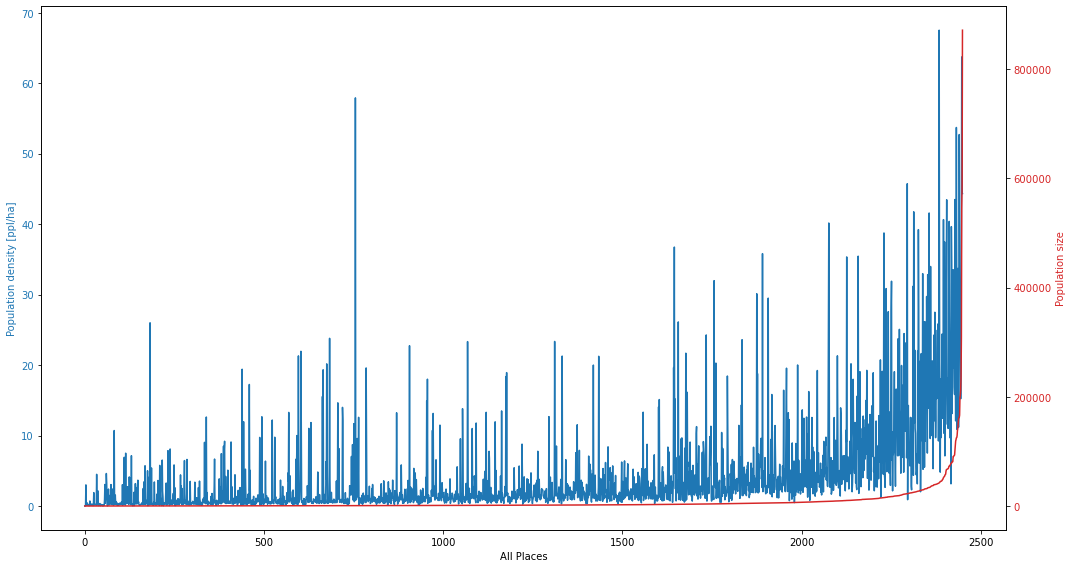

In [22]:
# Select data: x axis and two times y-axis
x = np.arange(0, 2495)
Pop_size = OrderedPlaces_df['Population_size']
Pop_density = OrderedPlaces_df['Population_density (ppl/ha)']

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('All Places')
ax1.set_ylabel('Population density [ppl/ha]', color=color)
ax1.plot(x, Pop_density, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Population size', color=color)  # we already handled the x-label with ax1
ax2.plot(x, Pop_size, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.set_size_inches(15, 8)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [25]:
#Save image for report
fig.savefig('Populations_SizeDensity.png', dpi=100)

We can see from this plot that Population size and density are largely correlated. And we can see that there are a few places, the big cities, with large population sizes.

In [27]:
print('Median Population size = ', OrderedPlaces_df['Population_size'].median())
print('Median Population density = ', OrderedPlaces_df['Population_density (ppl/ha)'].median())

Median Population size =  1535.0
Median Population density =  1.7027608608702496


As a start, we can say a minimum of 100000 means a big city. Let's see how many cities there are and what the distribution is of the rest.

In [11]:
city_threshold = 104000 #Delft has 103425 and I think it's too small to be a big city.'s-Hertogenbosch is next on the list (110690) and can be considered a city I believe

In [57]:
cities = OrderedPlaces_df[OrderedPlaces_df['Population_size'] > city_threshold]
cities

,Plc_code,Place_name,Municipality,Province,Latitude,Longitude,Population_size,Area_size (ha),Population_density (ppl/ha)
852,1595,'s-Hertogenbosch,'s-Hertogenbosch,Noord-Brabant,51.688935,5.303104,110690.0,6092.0,18.169731
427,2351,Dordrecht,Dordrecht,Zuid-Holland,51.795881,4.677935,119030.0,9848.0,12.086718
1257,1406,Maastricht,Maastricht,Limburg,50.851244,5.690977,121490.0,6013.0,20.204557
1152,2088,Leiden,Leiden,Zuid-Holland,52.151816,4.481109,125000.0,2327.0,53.717232
2453,2293,Zoetermeer,Zoetermeer,Zuid-Holland,52.062289,4.487755,125225.0,3704.0,33.808045
2499,1182,Zwolle,Zwolle,Overijssel,52.508976,6.094377,128775.0,11856.0,10.861589
87,3560,Apeldoorn,Apeldoorn,Gelderland,52.179574,5.930077,138185.0,5966.0,23.162085
60,1664,Amersfoort,Amersfoort,Utrecht,52.163774,5.396588,141690.0,4202.0,33.719657
280,3622,Breda,Breda,Noord-Brabant,51.588785,4.776024,150430.0,8358.0,17.998325
537,1145,Enschede,Enschede,Overijssel,52.220985,6.894054,159550.0,14274.0,11.177666


In [35]:
rest_df = OrderedPlaces_df[OrderedPlaces_df['Population_size'] <= city_threshold]
rest_df.shape

(2429, 9)

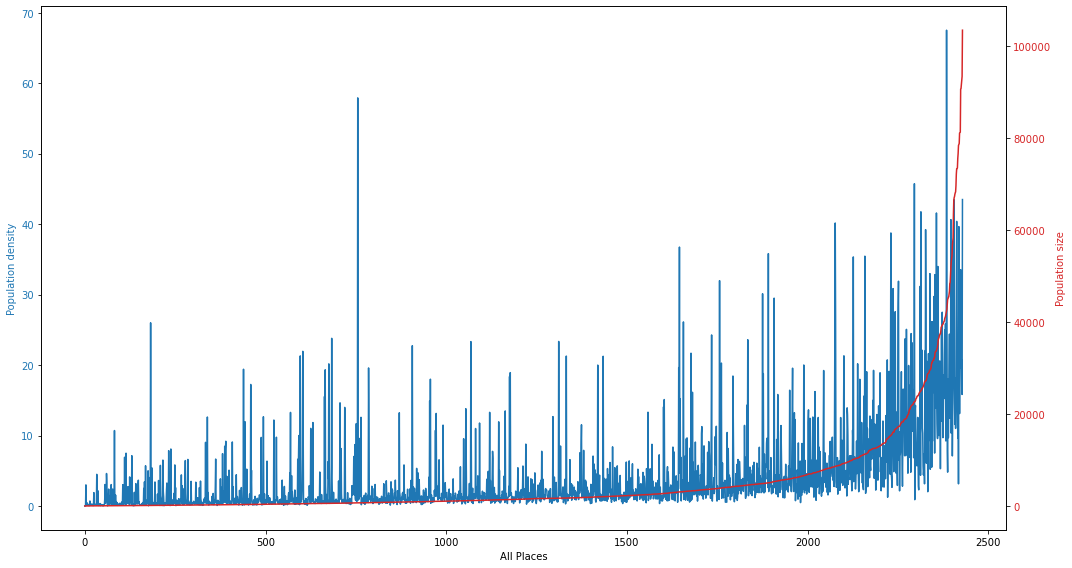

In [36]:
# Select data: x axis and two times y-axis
x = np.arange(0, 2429)
Pop_size = rest_df['Population_size']
Pop_density = rest_df['Population_density (ppl/ha)']

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('All Places')
ax1.set_ylabel('Population density', color=color)
ax1.plot(x, Pop_density, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Population size', color=color)  # we already handled the x-label with ax1
ax2.plot(x, Pop_size, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.set_size_inches(15, 8)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [12]:
big_town_threshold = 3000 #There is a sharp increase in the plot after this number, it seems to be reasonable to take as threshold

In [13]:
big_towns = OrderedPlaces_df[(OrderedPlaces_df['Population_size'] <= city_threshold) & (OrderedPlaces_df['Population_size']> big_town_threshold)]
big_towns.head(10)

,Plc_code,Place_name,Municipality,Province,Latitude,Longitude,Population_size,Area_size (ha),Population_density (ppl/ha)
1767,3465,Rilland,Reimerswaal,Zeeland,51.416475,4.181242,3035.0,5695.0,0.532924
2260,1417,Weerselo,Dinkelland,Overijssel,52.350863,6.853924,3040.0,1860.0,1.634409
277,2628,Brakel,Zaltbommel,Gelderland,51.817298,5.091407,3045.0,1040.0,2.927885
1050,1853,Klimmen,Voerendaal,Limburg,50.876207,5.882310,3045.0,155.0,19.645161
755,1349,Harkstede,Midden-Groningen,Groningen,53.213737,6.700359,3050.0,310.0,9.838710
1206,2978,Lobith,Zevenaar,Gelderland,51.861543,6.117675,3050.0,83.0,36.746988
970,2410,IJlst,Súdwest-Fryslân,Fryslân,53.009980,5.623673,3060.0,656.0,4.664634
1720,3254,Ravenstein,Oss,Noord-Brabant,51.794973,5.650933,3070.0,202.0,15.198020
1355,2592,Montfort,Roerdalen,Limburg,51.129387,5.945181,3075.0,1261.0,2.438541
946,2825,Huis ter Heide,Zeist,Utrecht,52.120604,5.261380,3080.0,446.0,6.905830


In [14]:
big_towns.shape

(789, 9)

In [15]:
town_threshold = 300 #minimum number of people to take a place into consideration, filters out noise and reduces numbers
small_towns = OrderedPlaces_df[(OrderedPlaces_df['Population_size'] <= big_town_threshold) & (OrderedPlaces_df['Population_size']> town_threshold)]
small_towns.tail(10)

,Plc_code,Place_name,Municipality,Province,Latitude,Longitude,Population_size,Area_size (ha),Population_density (ppl/ha)
702,1701,Gronsveld,Eijsden-Margraten,Limburg,50.811035,5.730829,2940.0,383.0,7.676240
600,2631,Gameren,Zaltbommel,Gelderland,51.800091,5.205736,2950.0,1326.0,2.224736
2233,2085,Wanroij,Sint Anthonis,Noord-Brabant,51.656977,5.820185,2950.0,2055.0,1.435523
1546,3076,Onstwedde,Stadskanaal,Groningen,53.036791,7.038894,2960.0,4057.0,0.729603
428,2959,Dorst,Oosterhout,Noord-Brabant,51.590250,4.859120,2960.0,942.0,3.142251
1073,3311,Kollumerzwaag,Noardeast-Fryslân,Fryslân,53.262828,6.079907,2970.0,1136.0,2.614437
1356,2803,Mook,Mook en Middelaar,Limburg,51.752582,5.884224,2980.0,695.0,4.287770
2491,2002,Zwartemeer,Emmen,Drenthe,52.722380,7.042561,2985.0,1608.0,1.856343
2272,1470,Wemeldinge,Kapelle,Zeeland,51.518383,3.995142,2995.0,852.0,3.515258
2328,3162,de Wijk,De Wolden,Drenthe,52.672069,6.288691,3000.0,1090.0,2.752294


In [16]:
small_towns.shape

(1229, 9)

In [41]:
city_threshold = 104000
big_town_threshold = 3000
small_town_threshold = 300

In [42]:
designation = []
for plc_code, pop in zip(PlacesNL_df['Plc_code'], PlacesNL_df['Population_size']):
    if pop > city_threshold:
        designation.append({
            "Plc_code": plc_code,
            "Designation":'city'
        })
    elif pop > big_town_threshold:
        designation.append({
            "Plc_code": plc_code,
            "Designation":'big_town'
        })
    elif pop > small_town_threshold:
        designation.append({
            "Plc_code": plc_code,
            "Designation":'small_town'
        })
    elif pop >0:
        designation.append({
            "Plc_code": plc_code,
            "Designation":'rural_area'
        })
    else:
         designation.append({
            "Plc_code": plc_code,
            "Designation":'empty'
        })

designation_df = pd.DataFrame(designation)
designation_df.head()
    

,Plc_code,Designation
0,1925,small_town
1,2774,small_town
2,2145,small_town
3,2571,big_town
4,1600,small_town


In [45]:
PlacesNL_df['Designation']= designation_df['Designation']
PlacesNL_df.head()

,Plc_code,Place_name,Municipality,Province,Latitude,Longitude,Population_size,Area_size (ha),Population_density (ppl/ha),Designation
0,1925,Aadorp,Almelo,Overijssel,52.375883,6.629603,1520.0,173.0,8.786127,small_town
1,2774,Aagtekerke,Veere,Zeeland,51.546524,3.510257,1505.0,991.0,1.518668,small_town
2,2145,Aalden,Coevorden,Drenthe,52.790411,6.710307,1930.0,1834.0,1.052345,small_town
3,2571,Aalsmeer,Aalsmeer,Noord-Holland,52.265834,4.766170,22575.0,2402.0,9.398418,big_town
4,1600,Aalsmeerderbrug,Haarlemmermeer,Noord-Holland,52.274006,4.749670,500.0,71.0,7.042254,small_town


I want a boxplot to see how the different sizes compare on Population_size and density.

In [51]:
#Get subset out of PlacesNL_df
bxplt_df = PlacesNL_df[['Designation','Population_size','Population_density (ppl/ha)']]
bxplt_df = bxplt_df[(bxplt_df['Designation'] != 'rural_area') & (bxplt_df['Designation'] != 'empty')]
print(bxplt_df.shape)
bxplt_df['Designation'].value_counts()

(2039, 3)


small_town    1229
big_town       789
city            21
Name: Designation, dtype: int64

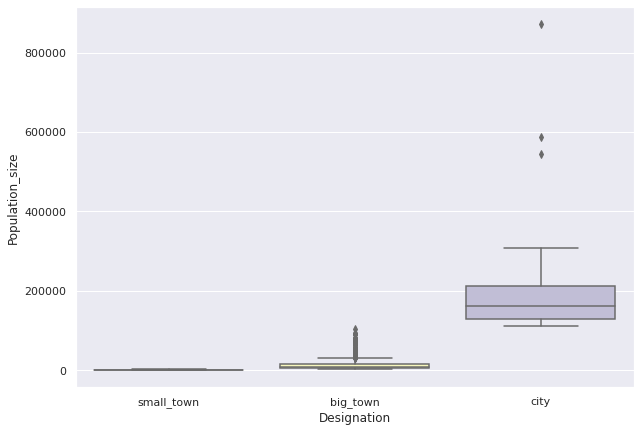

In [33]:
#Plot boxplot
fig, ax1 = plt.subplots()
fig.set_size_inches(10, 7)
sns.boxplot(x=bxplt_df['Designation'], y=bxplt_df['Population_size'], palette='Set3')
plt.show()

We can see there are 3 massive outliers in the city category. These are the mega-cities. I will exclude these to get a closer look on the data.

In [43]:
#Get subset out of PlacesNL_df
bxplt_df = PlacesNL_df[['Designation','Population_size','Population_density (ppl/ha)']]
bxplt_df = bxplt_df[(bxplt_df['Designation'] != 'too_small') & (bxplt_df['Designation'] != 'empty') & (bxplt_df['Population_size']<300000)]
print(bxplt_df.shape)
bxplt_df['Designation'].value_counts()

(2035, 3)


small_town    1229
big_town       789
city            17
Name: Designation, dtype: int64

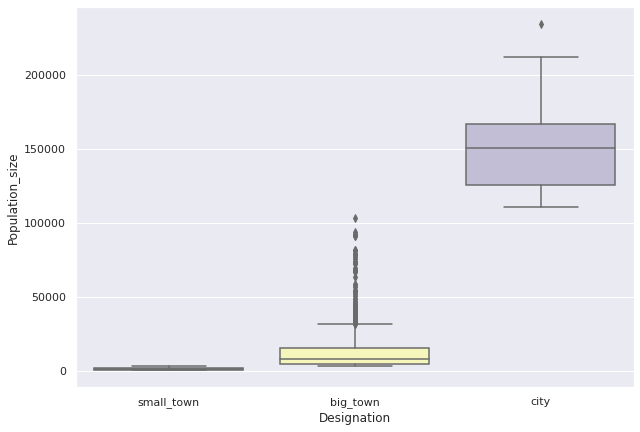

In [35]:
#Plot boxplot
fig, ax1 = plt.subplots()
fig.set_size_inches(10, 7)
sns.boxplot(x=bxplt_df['Designation'], y=bxplt_df['Population_size'], palette='Set3')
plt.show()

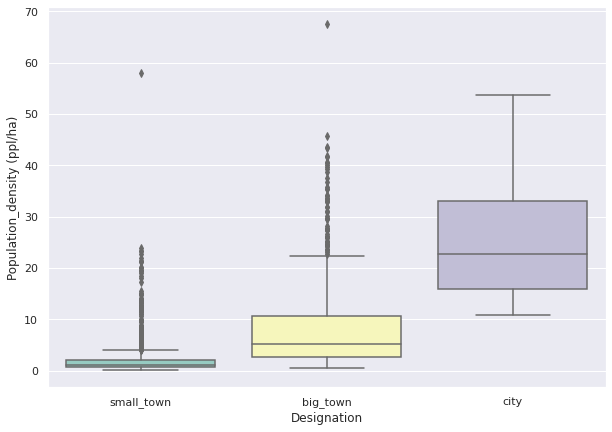

In [36]:
#Plot boxplot
fig, ax1 = plt.subplots()
fig.set_size_inches(10, 7)
sns.boxplot(x=bxplt_df['Designation'], y=bxplt_df['Population_density (ppl/ha)'], palette='Set3')
plt.show()

Interesting to look at some more stats and compare these in a table.

In [80]:
subset_df = PlacesNL_df[['Designation','Population_size','Area_size (ha)','Population_density (ppl/ha)']]
subset_df = subset_df[subset_df['Designation'] != 'empty']
print(subset_df.shape)
sum_df= subset_df[['Designation','Population_size','Area_size (ha)']].groupby(['Designation']).sum()
sum_df.reset_index(inplace=True)
sum_df.rename(columns={'Population_size':'Pop_size_sum', 'Area_size (ha)':'Area_size_sum (ha)'}, inplace=True)
#sum_df

(2450, 4)


In [81]:
median_df= subset_df[['Designation','Population_size','Population_density (ppl/ha)','Area_size (ha)']].groupby(['Designation']).median()
median_df.reset_index(inplace=True)
median_df.rename(columns={'Population_size':'Pop_size_median', 'Population_density (ppl/ha)':'Pop_density_median (ppl/ha)', 'Area_size (ha)':'Area_size_median (ha)'}, inplace=True)
#median_df

In [82]:
mean_df= subset_df[['Designation','Population_size','Population_density (ppl/ha)','Area_size (ha)']].groupby(['Designation']).mean()
mean_df.reset_index(inplace=True)
mean_df.rename(columns={'Population_size':'Pop_size_mean', 'Population_density (ppl/ha)':'Pop_density_mean (ppl/ha)', 'Area_size (ha)':'Area_size_mean (ha)'}, inplace=True)
#mean_df

In [83]:
count_df = subset_df['Designation'].value_counts().rename_axis('Designation').reset_index(name='Count')
#count_df

In [85]:
stats_df = pd.merge(count_df, sum_df, how='outer', on='Designation')
stats_df = pd.merge(stats_df, median_df, how='outer', on='Designation')
stats_df = pd.merge(stats_df, mean_df, how='outer', on='Designation')

#stats_df

In [86]:
stats_df['Pop_size (%)']= (stats_df['Pop_size_sum']/stats_df['Pop_size_sum'].sum())*100
stats_df['Count (%)']= (stats_df['Count']/stats_df['Count'].sum())*100
stats_df['Area_size (%)']= (stats_df['Area_size_sum (ha)']/stats_df['Area_size_sum (ha)'].sum())*100
stats_df

,Designation,Count,Pop_size_sum,Area_size_sum (ha),Pop_size_median,Pop_density_median (ppl/ha),Area_size_median (ha),Pop_size_mean,Pop_density_mean (ppl/ha),Area_size_mean (ha),Pop_size (%),Count (%),Area_size (%)
0,small_town,1229,1539370.0,1387037.0,1100.0,1.178591,910.0,1252.538649,2.207459,1128.589910,8.820409,50.163265,39.280637
1,big_town,789,10880630.0,1774674.0,7610.0,5.110169,1851.0,13790.405577,8.302603,2249.269962,62.344731,32.204082,50.258447
2,rural_area,411,62585.0,189715.0,150.0,0.391645,337.0,152.274939,1.198455,461.593674,0.358605,16.775510,5.372694
3,city,21,4969780.0,179670.0,161255.0,24.244596,8373.0,236656.190476,29.468848,8555.714286,28.476255,0.857143,5.088222


In [79]:
stats_df.to_sql('Statistics_TownsCities', engine) #Store a backup for report

### 1.3.2: For small towns, find distance to nearest big town and city

We'll need geopy again, loop through all places, calculate distances and determine the shortest lengths

In [87]:
from geopy import distance

In [88]:
PlacesNL_df.head()

,Plc_code,Place_name,Municipality,Province,Latitude,Longitude,Population_size,Area_size (ha),Population_density (ppl/ha),Designation
0,1925,Aadorp,Almelo,Overijssel,52.375883,6.629603,1520.0,173.0,8.786127,small_town
1,2774,Aagtekerke,Veere,Zeeland,51.546524,3.510257,1505.0,991.0,1.518668,small_town
2,2145,Aalden,Coevorden,Drenthe,52.790411,6.710307,1930.0,1834.0,1.052345,small_town
3,2571,Aalsmeer,Aalsmeer,Noord-Holland,52.265834,4.766170,22575.0,2402.0,9.398418,big_town
4,1600,Aalsmeerderbrug,Haarlemmermeer,Noord-Holland,52.274006,4.749670,500.0,71.0,7.042254,small_town


In [90]:
SmallTowns_df = PlacesNL_df[PlacesNL_df['Designation']=='small_town']
SmallTowns_df.head()

,Plc_code,Place_name,Municipality,Province,Latitude,Longitude,Population_size,Area_size (ha),Population_density (ppl/ha),Designation
0,1925,Aadorp,Almelo,Overijssel,52.375883,6.629603,1520.0,173.0,8.786127,small_town
1,2774,Aagtekerke,Veere,Zeeland,51.546524,3.510257,1505.0,991.0,1.518668,small_town
2,2145,Aalden,Coevorden,Drenthe,52.790411,6.710307,1930.0,1834.0,1.052345,small_town
4,1600,Aalsmeerderbrug,Haarlemmermeer,Noord-Holland,52.274006,4.749670,500.0,71.0,7.042254,small_town
5,2626,Aalst,Zaltbommel,Gelderland,51.783660,5.129342,2380.0,1126.0,2.113677,small_town


In [91]:
BigTowns_df = PlacesNL_df[PlacesNL_df['Designation']=='big_town']
BigTowns_df.head()

,Plc_code,Place_name,Municipality,Province,Latitude,Longitude,Population_size,Area_size (ha),Population_density (ppl/ha),Designation
3,2571,Aalsmeer,Aalsmeer,Noord-Holland,52.265834,4.766170,22575.0,2402.0,9.398418,big_town
7,1193,Aalten,Aalten,Gelderland,51.914182,6.577399,17355.0,8066.0,2.151624,big_town
8,2673,Ter Aar,Nieuwkoop,Zuid-Holland,52.165573,4.709364,9410.0,2169.0,4.338405,big_town
12,1445,Aarle-Rixtel,Laarbeek,Noord-Brabant,51.509812,5.637875,5725.0,1359.0,4.212656,big_town
18,1332,Abcoude,De Ronde Venen,Utrecht,52.270281,4.971043,8100.0,2273.0,3.563572,big_town


In [92]:
City_df = PlacesNL_df[PlacesNL_df['Designation']=='city']
City_df.head()

,Plc_code,Place_name,Municipality,Province,Latitude,Longitude,Population_size,Area_size (ha),Population_density (ppl/ha),Designation
45,1270,Almere,Almere,Flevoland,52.365710,5.221043,211800.0,13920.0,15.215517,city
60,1664,Amersfoort,Amersfoort,Utrecht,52.163774,5.396588,141690.0,4202.0,33.719657,city
66,3594,Amsterdam,Amsterdam,Noord-Holland,52.372760,4.893604,871395.0,19651.0,44.343545,city
87,3560,Apeldoorn,Apeldoorn,Gelderland,52.179574,5.930077,138185.0,5966.0,23.162085,city
95,1296,Arnhem,Arnhem,Gelderland,51.984257,5.910857,161255.0,10159.0,15.873117,city


In [98]:
distCity_lst = []
for plc_code, lat, lon in zip(SmallTowns_df['Plc_code'],SmallTowns_df['Latitude'],SmallTowns_df['Longitude']):
    town_coor = (lat, lon)
    nearest_dis = 10000
    nearest_plc_code = 5000
    nearest_plc = 'blatown'
    for plc2_code, plc_name, lat2, lon2 in zip(City_df['Plc_code'],City_df['Place_name'], City_df['Latitude'],City_df['Longitude']):
        city_coor = (lat2,lon2)
        dis = distance.distance(town_coor,city_coor).km
        if dis < nearest_dis:
            nearest_dis = dis
            nearest_plc_code = plc2_code
            nearest_plc = plc_name
            
    distCity_lst.append({
        "Plc_code": plc_code,
        "Distance city": nearest_dis,
        "Nearest City": nearest_plc,
        "Nearest City code": nearest_plc_code
    })
distCity_df = pd.DataFrame(distCity_lst)
distCity_df.head()

,Plc_code,Distance city,Nearest City,Nearest City code
0,1925,24.950937,Enschede,1145
1,2774,78.020086,Rotterdam,3086
2,2145,48.650420,Groningen,1070
3,1600,14.189128,Haarlem,2907
4,2626,15.973867,'s-Hertogenbosch,1595


In [99]:
distBigTown_lst = []
for plc_code, lat, lon in zip(SmallTowns_df['Plc_code'],SmallTowns_df['Latitude'],SmallTowns_df['Longitude']):
    town_coor = (lat, lon)
    nearest_dis = 10000
    nearest_plc_code = 5000
    nearest_plc = 'blatown'
    for plc2_code, plc_name, lat2, lon2 in zip(BigTowns_df['Plc_code'],BigTowns_df['Place_name'], BigTowns_df['Latitude'],BigTowns_df['Longitude']):
        bigTown_coor = (lat2,lon2)
        dis = distance.distance(town_coor,bigTown_coor).km
        if dis < nearest_dis:
            nearest_dis = dis
            nearest_plc_code = plc2_code
            nearest_plc = plc_name
            
    distBigTown_lst.append({
        "Plc_code": plc_code,
        "Distance Big Town": nearest_dis,
        "Nearest Big Town": nearest_plc,
        "Nearest Big Town code": nearest_plc_code
    })
distBigTown_df = pd.DataFrame(distBigTown_lst)
distBigTown_df.head()

,Plc_code,Distance Big Town,Nearest Big Town,Nearest Big Town code
0,1925,3.329856,Almelo,1924
1,2774,7.782320,Koudekerke,2779
2,2145,9.395515,Westerbork,3025
3,1600,1.447609,Aalsmeer,2571
4,2626,2.852996,Wijk en Aalburg,1957


In [102]:
#Merge with SmallTowns_df
SmallTowns_df['Distance Big Town'] = distBigTown_df['Distance Big Town']
SmallTowns_df['Nearest Big Town'] = distBigTown_df['Nearest Big Town']
SmallTowns_df['Nearest Big Town code'] = distBigTown_df['Nearest Big Town code']
SmallTowns_df['Distance City'] = distCity_df['Distance city']
SmallTowns_df['Nearest City'] = distCity_df['Nearest City']
SmallTowns_df['Nearest City code'] = distCity_df['Nearest City code']

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

In [103]:
SmallTowns_df.drop(['Designation'], axis=1, inplace=True)


/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Plc_code,Place_name,Municipality,Province,Latitude,Longitude,Population_size,Area_size (ha),Population_density (ppl/ha),Distance Big Town,Nearest Big Town,Nearest Big Town code,Distance City,Nearest City,Nearest City code
0,1925,Aadorp,Almelo,Overijssel,52.375883,6.629603,1520.0,173.0,8.786127,3.329856,Almelo,1924,24.950937,Enschede,1145
1,2774,Aagtekerke,Veere,Zeeland,51.546524,3.510257,1505.0,991.0,1.518668,7.782320,Koudekerke,2779,78.020086,Rotterdam,3086
2,2145,Aalden,Coevorden,Drenthe,52.790411,6.710307,1930.0,1834.0,1.052345,9.395515,Westerbork,3025,48.650420,Groningen,1070
4,1600,Aalsmeerderbrug,Haarlemmermeer,Noord-Holland,52.274006,4.749670,500.0,71.0,7.042254,2.852996,Wijk en Aalburg,1957,15.973867,'s-Hertogenbosch,1595
5,2626,Aalst,Zaltbommel,Gelderland,51.783660,5.129342,2380.0,1126.0,2.113677,6.803907,Oostburg,2960,99.197880,Breda,3622


In [104]:
SmallTowns_df.head()

,Plc_code,Place_name,Municipality,Province,Latitude,Longitude,Population_size,Area_size (ha),Population_density (ppl/ha),Distance Big Town,Nearest Big Town,Nearest Big Town code,Distance City,Nearest City,Nearest City code
0,1925,Aadorp,Almelo,Overijssel,52.375883,6.629603,1520.0,173.0,8.786127,3.329856,Almelo,1924,24.950937,Enschede,1145
1,2774,Aagtekerke,Veere,Zeeland,51.546524,3.510257,1505.0,991.0,1.518668,7.782320,Koudekerke,2779,78.020086,Rotterdam,3086
2,2145,Aalden,Coevorden,Drenthe,52.790411,6.710307,1930.0,1834.0,1.052345,9.395515,Westerbork,3025,48.650420,Groningen,1070
4,1600,Aalsmeerderbrug,Haarlemmermeer,Noord-Holland,52.274006,4.749670,500.0,71.0,7.042254,2.852996,Wijk en Aalburg,1957,15.973867,'s-Hertogenbosch,1595
5,2626,Aalst,Zaltbommel,Gelderland,51.783660,5.129342,2380.0,1126.0,2.113677,6.803907,Oostburg,2960,99.197880,Breda,3622


In [105]:
SmallTowns_df.to_sql('SmallTowns_Overview', engine) #Store a backup for report

### 1.3 Distribution plot

In [16]:
#Read table into dataframe
query = 'SELECT "Plc_code", "Place_name", "Municipality", "Province", "Latitude", "Longitude", "Population_size", "Area_size (ha)", "Population_density (ppl/ha)", "Distance Big Town", "Nearest Big Town", "Nearest Big Town code", "Distance City", "Nearest City", "Nearest City code" FROM "VSR62892"."SmallTowns_Overview";'
SmallTowns_df = pd.read_sql_query(query, engine)
SmallTowns_df.head()

,Plc_code,Place_name,Municipality,Province,Latitude,Longitude,Population_size,Area_size (ha),Population_density (ppl/ha),Distance Big Town,Nearest Big Town,Nearest Big Town code,Distance City,Nearest City,Nearest City code
0,1925,Aadorp,Almelo,Overijssel,52.375883,6.629603,1520.0,173.0,8.786127,3.329856,Almelo,1924,24.950937,Enschede,1145
1,2774,Aagtekerke,Veere,Zeeland,51.546524,3.510257,1505.0,991.0,1.518668,7.782320,Koudekerke,2779,78.020086,Rotterdam,3086
2,2145,Aalden,Coevorden,Drenthe,52.790411,6.710307,1930.0,1834.0,1.052345,9.395515,Westerbork,3025,48.650420,Groningen,1070
3,1600,Aalsmeerderbrug,Haarlemmermeer,Noord-Holland,52.274006,4.749670,500.0,71.0,7.042254,2.852996,Wijk en Aalburg,1957,15.973867,'s-Hertogenbosch,1595
4,2626,Aalst,Zaltbommel,Gelderland,51.783660,5.129342,2380.0,1126.0,2.113677,6.803907,Oostburg,2960,99.197880,Breda,3622


In [17]:
print('Median distance to City = ', SmallTowns_df[['Distance City']].median())
print('Median distance to Big Town = ', SmallTowns_df[['Distance Big Town']].median())

Median distance to City =  Distance City    26.795941
dtype: float64
Median distance to Big Town =  Distance Big Town    3.748884
dtype: float64


In [18]:
print('Mean distance to City = ', SmallTowns_df[['Distance City']].mean())
print('Mean distance to Big Town = ', SmallTowns_df[['Distance Big Town']].mean())

Mean distance to City =  Distance City    31.349992
dtype: float64
Mean distance to Big Town =  Distance Big Town    4.144156
dtype: float64


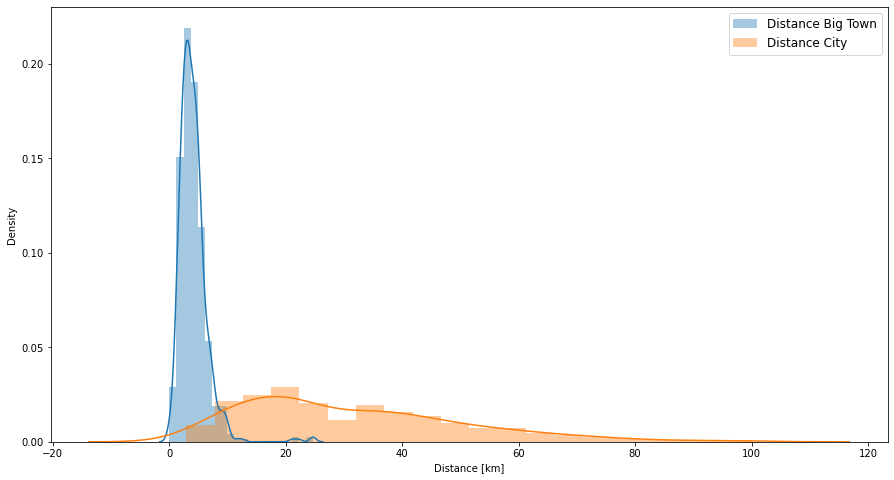

In [24]:
histplt_df = SmallTowns_df[['Distance Big Town','Distance City']]

fig, ax1 = plt.subplots()
fig.set_size_inches(15, 8)

sns.distplot(histplt_df['Distance Big Town'] , kde=True, norm_hist=False, label='Distance Big Town', bins=20)
sns.distplot(histplt_df['Distance City'] , kde=True, norm_hist=False, label='Distance City', bins=20)

# Plot formatting
plt.legend(prop={'size': 12})
#plt.title('Life Expectancy of Two Continents')
plt.xlabel('Distance [km]')
plt.ylabel('Density')

plt.show()


We want to select towns both at some distance from city and big town, but also end up with a decent sample size. Selecting the peaks of the former plots seems to be a reasonable trade-off.

In [27]:
city_dis_th = 15
bigtown_dis_th = 4

In [28]:
SmallRuralTowns_df = SmallTowns_df[(SmallTowns_df['Distance Big Town']>bigtown_dis_th) & (SmallTowns_df['Distance City']>city_dis_th)]
#big_towns = OrderedPlaces_df[(OrderedPlaces_df['Population_size'] <= city_threshold) & (OrderedPlaces_df['Population_size']> big_town_threshold)]
SmallRuralTowns_df.shape

(249, 15)

In [29]:
SmallRuralTowns_df.head()

,Plc_code,Place_name,Municipality,Province,Latitude,Longitude,Population_size,Area_size (ha),Population_density (ppl/ha),Distance Big Town,Nearest Big Town,Nearest Big Town code,Distance City,Nearest City,Nearest City code
1,2774,Aagtekerke,Veere,Zeeland,51.546524,3.510257,1505.0,991.0,1.518668,7.782320,Koudekerke,2779,78.020086,Rotterdam,3086
2,2145,Aalden,Coevorden,Drenthe,52.790411,6.710307,1930.0,1834.0,1.052345,9.395515,Westerbork,3025,48.650420,Groningen,1070
4,2626,Aalst,Zaltbommel,Gelderland,51.783660,5.129342,2380.0,1126.0,2.113677,6.803907,Oostburg,2960,99.197880,Breda,3622
6,1079,Aarlanderveen,Alphen aan den Rijn,Zuid-Holland,52.141360,4.728552,1195.0,1992.0,0.599900,5.570735,Harlingen,2891,72.865785,Groningen,1070
7,2788,Aartswoud,Opmeer,Noord-Holland,52.745074,4.956798,485.0,401.0,1.209476,4.676602,Oude-Tonge,2134,29.075221,Rotterdam,3086


We now have 249 places, with population size between 300 and 3000 and at a minimum distance of 15km to the nearest city and 4km to the nearest big town. I will save a backup of this dataframe so I can work with it later.

In [34]:
SmallRuralTowns_df.to_sql('SmallRuralTowns_Overview', engine) #Store a backup for report

In [4]:
#Read table into dataframe
query = 'SELECT "Plc_code", "Place_name", "Municipality", "Province", "Latitude", "Longitude", "Population_size", "Area_size (ha)", "Population_density (ppl/ha)", "Distance Big Town", "Nearest Big Town", "Nearest Big Town code", "Distance City", "Nearest City", "Nearest City code" FROM "VSR62892"."SmallRuralTowns_Overview";'
SmallRuralTowns_df = pd.read_sql_query(query, engine)
SmallRuralTowns_df.head()

,Plc_code,Place_name,Municipality,Province,Latitude,Longitude,Population_size,Area_size (ha),Population_density (ppl/ha),Distance Big Town,Nearest Big Town,Nearest Big Town code,Distance City,Nearest City,Nearest City code
0,1925,Aadorp,Almelo,Overijssel,52.375883,6.629603,1520.0,173.0,8.786127,3.329856,Almelo,1924,24.950937,Enschede,1145
1,2774,Aagtekerke,Veere,Zeeland,51.546524,3.510257,1505.0,991.0,1.518668,7.782320,Koudekerke,2779,78.020086,Rotterdam,3086
2,2145,Aalden,Coevorden,Drenthe,52.790411,6.710307,1930.0,1834.0,1.052345,9.395515,Westerbork,3025,48.650420,Groningen,1070
3,2626,Aalst,Zaltbommel,Gelderland,51.783660,5.129342,2380.0,1126.0,2.113677,6.803907,Oostburg,2960,99.197880,Breda,3622
4,1079,Aarlanderveen,Alphen aan den Rijn,Zuid-Holland,52.141360,4.728552,1195.0,1992.0,0.599900,5.570735,Harlingen,2891,72.865785,Groningen,1070


In [7]:
#Install and import Folium
!pip install folium
import folium # map rendering library

print('Folium imported')

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 94 kB 7.9 MB/s  eta 0:00:01
Folium imported


In [51]:

#Utrecht City Coordinates (=central location)
Utrecht_coor = [52.080986, 5.127684]

# Sample (0.33% over 1.5 million) 
#sample_coords = rnd.sample(list(coords),5000)''

# Build map 
map_NL = folium.Map(location=Utrecht_coor, zoom_start=8, tiles='cartodbpositron', width=800, height=900)

# add markers to the map
#markers_colors = []
for lat,lon,plc in zip(SmallRuralTowns_df['Latitude'], SmallRuralTowns_df['Longitude'], SmallRuralTowns_df['Place_name']):
    label = folium.Popup(str(plc), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=1,
        popup=label,
        color='#0080bb',
        fill=True,
        fill_color='#0080bb',
        fill_opacity=0.7).add_to(map_NL)


# Display map in Jupyter
map_NL

# Part 2: Assessment of Rural Towns

I now want to make an assessment of the health of the selected Towns. One common metric is population growth. CBS has a table, 83502NED, that contains all population counts back to the year 1998. Data is listed per 4-digit-Postalcode, so I'll have to select and group the information again like in section 1.1.4.

In [57]:
# The code was removed by Watson Studio for sharing.

,ID,Geslacht,Leeftijd,Postcode,Perioden,Bevolking_1
0,0,T001038,10000,NL01,1998JJ00,15654192.0
1,1,T001038,10000,NL01,1999JJ00,15760225.0
2,2,T001038,10000,NL01,2000JJ00,15863950.0
3,3,T001038,10000,NL01,2001JJ00,15987075.0
4,4,T001038,10000,NL01,2002JJ00,16105285.0


In [58]:
print(df_data_4.shape)
df_data_4.head()

(93702, 6)


,ID,Geslacht,Leeftijd,Postcode,Perioden,Bevolking_1
0,0,T001038,10000,NL01,1998JJ00,15654192.0
1,1,T001038,10000,NL01,1999JJ00,15760225.0
2,2,T001038,10000,NL01,2000JJ00,15863950.0
3,3,T001038,10000,NL01,2001JJ00,15987075.0
4,4,T001038,10000,NL01,2002JJ00,16105285.0


In [59]:
df_data_4.dtypes

ID               int64
Geslacht        object
Leeftijd         int64
Postcode        object
Perioden        object
Bevolking_1    float64
dtype: object

I have downloaded the table in full, but I don't need 'ID','Geslacht' and 'Leeftijd'. I can drop these to reduce the size

In [60]:
df_data_4.drop(['ID','Geslacht','Leeftijd'], axis=1, inplace=True)
df_data_4.head()

,Postcode,Perioden,Bevolking_1
0,NL01,1998JJ00,15654192.0
1,NL01,1999JJ00,15760225.0
2,NL01,2000JJ00,15863950.0
3,NL01,2001JJ00,15987075.0
4,NL01,2002JJ00,16105285.0


In [119]:
lst = []
PC4_df = pd.DataFrame(lst)
PC4_df['4_digit_Postalcode'] = df_data_4['Postcode'].unique()
PC4_df.head(10)

,4_digit_Postalcode
0,NL01
1,PC0999
2,PC1011
3,PC1012
4,PC1013
5,PC1014
6,PC1015
7,PC1016
8,PC1017
9,PC1018


In [66]:
lst = []
Periods_df = pd.DataFrame(lst)
Periods_df['Year'] = df_data_4['Perioden'].unique()
Periods_df.head()

,Year
0,1998JJ00
1,1999JJ00
2,2000JJ00
3,2001JJ00
4,2002JJ00


In [70]:
print('Number of unique Postalcodes: ', PC4_df.shape[0])
print('Number of unique years: ', Periods_df.shape[0])

Number of unique Postalcodes:  4074
Number of unique years:  23


In [72]:
pd.options.display.max_columns = 30

In [142]:
#yr = Periods_df['Year'][0]
#pc4 = PC4_df['4_digit_Postalcode'][0]
#print(yr,' ', pc4)
#sub_df=df_data_4.loc[(df_data_4['Perioden']==yr) & (df_data_4['Postcode']==pc4)]
#int(sub_df['Bevolking_1'])
#subs_df= PC4_df.head(30)

Pop9820_lst =[]
#Pop_dct={}
for pc4 in PC4_df['4_digit_Postalcode']:
    Pop_dct={}
    pc4_clean = pc4.strip()
    Pop_dct["Postalcode"] = pc4_clean
    for yr in Periods_df['Year']:
        yr_clean = yr.strip()
        yr_clean = yr[0:4]
        sub_df=df_data_4.loc[(df_data_4['Perioden']==yr) & (df_data_4['Postcode']==pc4)]
        popu =sub_df['Bevolking_1']
        try:
            popu = int(popu)
        except:
            popu=np.nan
        Pop_dct[yr_clean]=popu
    Pop9820_lst.append(Pop_dct)

Pop9820_df = pd.DataFrame(Pop9820_lst)
Pop9820_df.head(30)


,Postalcode,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,NL01,15654192.0,15760225.0,15863950.0,15987075.0,16105285.0,16192572.0,16258032.0,16305526.0,16334210.0,16357992.0,16405399.0,16485787.0,16574989.0,16655799.0,16730348.0,16779575.0,16829289.0,16900726.0,16979120.0,17081507.0,17181084.0,17282163.0,17407585.0
1,PC0999,9160.0,9925.0,7470.0,8060.0,6330.0,5590.0,5590.0,6300.0,5845.0,4955.0,4615.0,4225.0,4235.0,3915.0,2790.0,2435.0,2395.0,1695.0,1565.0,1170.0,1120.0,1835.0,2035.0
2,PC1011,7935.0,8460.0,8695.0,8655.0,8660.0,8620.0,8760.0,8895.0,8815.0,8545.0,8660.0,8775.0,8810.0,9000.0,9025.0,9320.0,9410.0,9540.0,9605.0,9645.0,9765.0,9670.0,9705.0
3,PC1012,7680.0,7740.0,7730.0,7760.0,7610.0,7410.0,7015.0,7050.0,7200.0,7235.0,7470.0,7500.0,8065.0,8025.0,8065.0,8090.0,8285.0,8440.0,8245.0,8235.0,8235.0,8420.0,8600.0
4,PC1013,18630.0,18660.0,18605.0,18745.0,18650.0,18570.0,18560.0,18755.0,19195.0,18900.0,19040.0,19720.0,20450.0,21180.0,21555.0,21570.0,21560.0,21635.0,21180.0,21080.0,21135.0,21335.0,21395.0
5,PC1014,135.0,130.0,110.0,115.0,115.0,115.0,120.0,130.0,145.0,155.0,165.0,200.0,210.0,215.0,235.0,250.0,235.0,535.0,585.0,645.0,620.0,1740.0,2180.0
6,PC1015,14510.0,14610.0,14660.0,14695.0,14705.0,14990.0,15780.0,15855.0,15890.0,15665.0,15620.0,14460.0,14605.0,14600.0,14685.0,14670.0,14770.0,14880.0,14860.0,14810.0,14895.0,14885.0,14865.0
7,PC1016,10585.0,10750.0,10695.0,10500.0,10550.0,10495.0,10555.0,10720.0,10800.0,10660.0,10475.0,10445.0,10550.0,10685.0,10815.0,10845.0,10960.0,10950.0,11005.0,10870.0,10935.0,10915.0,10980.0
8,PC1017,11530.0,11740.0,11700.0,11725.0,11515.0,11430.0,11545.0,11845.0,12000.0,11980.0,11890.0,11915.0,12100.0,12370.0,12420.0,12610.0,12695.0,12730.0,12785.0,12665.0,12585.0,12645.0,12730.0
9,PC1018,19090.0,19240.0,19125.0,18990.0,18975.0,19110.0,19145.0,19555.0,20000.0,19495.0,19920.0,20000.0,19820.0,20205.0,20455.0,20795.0,20535.0,20500.0,20500.0,20830.0,21010.0,20920.0,21110.0


In [155]:
Pop9820_df.rename(columns={'2000':' 2000', '2001':' 2001', '2002':' 2002', '2003':' 2003', '2004':' 2004', '2005':' 2005', '2006':' 2006', '2007':' 2007', '2008':' 2008', '2009':' 2009', '2010':' 2010',
                          '2011':' 2011', '2012':' 2012','2013':' 2013','2014':' 2014','2015':' 2015','2016':' 2016','2017':' 2017','2018':' 2018','2019':' 2019','2020':' 2020'},
                 inplace=True)
Pop9820_df.head()

,Postalcode,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,NL01,15654192.0,15760225.0,15863950.0,15987075.0,16105285.0,16192572.0,16258032.0,16305526.0,16334210.0,16357992.0,16405399.0,16485787.0,16574989.0,16655799.0,16730348.0,16779575.0,16829289.0,16900726.0,16979120.0,17081507.0,17181084.0,17282163.0,17407585.0
1,PC0999,9160.0,9925.0,7470.0,8060.0,6330.0,5590.0,5590.0,6300.0,5845.0,4955.0,4615.0,4225.0,4235.0,3915.0,2790.0,2435.0,2395.0,1695.0,1565.0,1170.0,1120.0,1835.0,2035.0
2,PC1011,7935.0,8460.0,8695.0,8655.0,8660.0,8620.0,8760.0,8895.0,8815.0,8545.0,8660.0,8775.0,8810.0,9000.0,9025.0,9320.0,9410.0,9540.0,9605.0,9645.0,9765.0,9670.0,9705.0
3,PC1012,7680.0,7740.0,7730.0,7760.0,7610.0,7410.0,7015.0,7050.0,7200.0,7235.0,7470.0,7500.0,8065.0,8025.0,8065.0,8090.0,8285.0,8440.0,8245.0,8235.0,8235.0,8420.0,8600.0
4,PC1013,18630.0,18660.0,18605.0,18745.0,18650.0,18570.0,18560.0,18755.0,19195.0,18900.0,19040.0,19720.0,20450.0,21180.0,21555.0,21570.0,21560.0,21635.0,21180.0,21080.0,21135.0,21335.0,21395.0


In [156]:
Pop9820_df.to_sql("Populations_Decades", engine) #Store a backup on Db2

In [20]:
#Read into dataframe
query = 'SELECT "Postalcode", " 1998", " 1999", " 2000", " 2001", " 2002", " 2003", " 2004", " 2005", " 2006", " 2007", " 2008", " 2009", " 2010", " 2011", " 2012", " 2013", " 2014", " 2015", " 2016", " 2017", " 2018", " 2019", " 2020" FROM "VSR62892"."Populations_Decades";'
Pop9820_df = pd.read_sql_query(query, engine)
#Pop9820_df.head()

In [21]:
Pop9820_df.drop([0],inplace=True)
#Pop9820_df.head()

In [22]:
Pop9820_df['4_digit_Postalcode']=Pop9820_df['Postalcode'].str[2:]
#Pop9820_df.head()

In [23]:
cols = ['4_digit_Postalcode','Postalcode',
 ' 1998',
 ' 1999',
 ' 2000',
 ' 2001',
 ' 2002',
 ' 2003',
 ' 2004',
 ' 2005',
 ' 2006',
 ' 2007',
 ' 2008',
 ' 2009',
 ' 2010',
 ' 2011',
 ' 2012',
 ' 2013',
 ' 2014',
 ' 2015',
 ' 2016',
 ' 2017',
 ' 2018',
 ' 2019',
 ' 2020']

In [24]:
Pop9820_df=Pop9820_df[cols]
Pop9820_df.head()

,4_digit_Postalcode,Postalcode,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
1,0999,PC0999,9160.0,9925.0,7470.0,8060.0,6330.0,5590.0,5590.0,6300.0,5845.0,4955.0,4615.0,4225.0,4235.0,3915.0,2790.0,2435.0,2395.0,1695.0,1565.0,1170.0,1120.0,1835.0,2035.0
2,1011,PC1011,7935.0,8460.0,8695.0,8655.0,8660.0,8620.0,8760.0,8895.0,8815.0,8545.0,8660.0,8775.0,8810.0,9000.0,9025.0,9320.0,9410.0,9540.0,9605.0,9645.0,9765.0,9670.0,9705.0
3,1012,PC1012,7680.0,7740.0,7730.0,7760.0,7610.0,7410.0,7015.0,7050.0,7200.0,7235.0,7470.0,7500.0,8065.0,8025.0,8065.0,8090.0,8285.0,8440.0,8245.0,8235.0,8235.0,8420.0,8600.0
4,1013,PC1013,18630.0,18660.0,18605.0,18745.0,18650.0,18570.0,18560.0,18755.0,19195.0,18900.0,19040.0,19720.0,20450.0,21180.0,21555.0,21570.0,21560.0,21635.0,21180.0,21080.0,21135.0,21335.0,21395.0
5,1014,PC1014,135.0,130.0,110.0,115.0,115.0,115.0,120.0,130.0,145.0,155.0,165.0,200.0,210.0,215.0,235.0,250.0,235.0,535.0,585.0,645.0,620.0,1740.0,2180.0


In [97]:
#Read PC4_df table into dataframe
query = 'SELECT  "4_digit_Postalcode","Place_code", "Place_name",  "Municipality", "Province" FROM "VSR62892"."PostalCodes_vs_Places";'
PC4_df = pd.read_sql_query(query, engine)
PC4_df.head()

,4_digit_Postalcode,Place_code,Place_name,Municipality,Province
0,1011,3594,Amsterdam,Amsterdam,Noord-Holland
1,1012,3594,Amsterdam,Amsterdam,Noord-Holland
2,1013,3594,Amsterdam,Amsterdam,Noord-Holland
3,1014,3594,Amsterdam,Amsterdam,Noord-Holland
4,1015,3594,Amsterdam,Amsterdam,Noord-Holland


In [27]:
PC4_df.dtypes

4_digit_Postalcode     int64
Place_code            object
Place_name            object
Municipality          object
Province              object
dtype: object

Now merge, inner, PC4_df and Pop9820_df on 4_digit_Postalcode

In [29]:
#Pop9820_df = pd.merge(Pop9820_df, PC4_df, how='inner', on='4_digit_Postalcode')
Pop9820_df=Pop9820_df.astype({'4_digit_Postalcode': 'int64'})

In [31]:
Pop9820_df.drop(['Postalcode'], axis=1, inplace=True)
Pop9820_df.head()

,4_digit_Postalcode,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
1,999,9160.0,9925.0,7470.0,8060.0,6330.0,5590.0,5590.0,6300.0,5845.0,4955.0,4615.0,4225.0,4235.0,3915.0,2790.0,2435.0,2395.0,1695.0,1565.0,1170.0,1120.0,1835.0,2035.0
2,1011,7935.0,8460.0,8695.0,8655.0,8660.0,8620.0,8760.0,8895.0,8815.0,8545.0,8660.0,8775.0,8810.0,9000.0,9025.0,9320.0,9410.0,9540.0,9605.0,9645.0,9765.0,9670.0,9705.0
3,1012,7680.0,7740.0,7730.0,7760.0,7610.0,7410.0,7015.0,7050.0,7200.0,7235.0,7470.0,7500.0,8065.0,8025.0,8065.0,8090.0,8285.0,8440.0,8245.0,8235.0,8235.0,8420.0,8600.0
4,1013,18630.0,18660.0,18605.0,18745.0,18650.0,18570.0,18560.0,18755.0,19195.0,18900.0,19040.0,19720.0,20450.0,21180.0,21555.0,21570.0,21560.0,21635.0,21180.0,21080.0,21135.0,21335.0,21395.0
5,1014,135.0,130.0,110.0,115.0,115.0,115.0,120.0,130.0,145.0,155.0,165.0,200.0,210.0,215.0,235.0,250.0,235.0,535.0,585.0,645.0,620.0,1740.0,2180.0


In [32]:
Pop9820_df = pd.merge(Pop9820_df, PC4_df, how='inner', on='4_digit_Postalcode')
Pop9820_df.head()

,4_digit_Postalcode,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2013,2014,2015,2016,2017,2018,2019,2020,Place_code,Place_name,Municipality,Province
0,1011,7935.0,8460.0,8695.0,8655.0,8660.0,8620.0,8760.0,8895.0,8815.0,8545.0,8660.0,...,9320.0,9410.0,9540.0,9605.0,9645.0,9765.0,9670.0,9705.0,3594,Amsterdam,Amsterdam,Noord-Holland
1,1012,7680.0,7740.0,7730.0,7760.0,7610.0,7410.0,7015.0,7050.0,7200.0,7235.0,7470.0,...,8090.0,8285.0,8440.0,8245.0,8235.0,8235.0,8420.0,8600.0,3594,Amsterdam,Amsterdam,Noord-Holland
2,1013,18630.0,18660.0,18605.0,18745.0,18650.0,18570.0,18560.0,18755.0,19195.0,18900.0,19040.0,...,21570.0,21560.0,21635.0,21180.0,21080.0,21135.0,21335.0,21395.0,3594,Amsterdam,Amsterdam,Noord-Holland
3,1014,135.0,130.0,110.0,115.0,115.0,115.0,120.0,130.0,145.0,155.0,165.0,...,250.0,235.0,535.0,585.0,645.0,620.0,1740.0,2180.0,3594,Amsterdam,Amsterdam,Noord-Holland
4,1015,14510.0,14610.0,14660.0,14695.0,14705.0,14990.0,15780.0,15855.0,15890.0,15665.0,15620.0,...,14670.0,14770.0,14880.0,14860.0,14810.0,14895.0,14885.0,14865.0,3594,Amsterdam,Amsterdam,Noord-Holland


In [33]:
list(Pop9820_df.columns.values)

['4_digit_Postalcode',
 ' 1998',
 ' 1999',
 ' 2000',
 ' 2001',
 ' 2002',
 ' 2003',
 ' 2004',
 ' 2005',
 ' 2006',
 ' 2007',
 ' 2008',
 ' 2009',
 ' 2010',
 ' 2011',
 ' 2012',
 ' 2013',
 ' 2014',
 ' 2015',
 ' 2016',
 ' 2017',
 ' 2018',
 ' 2019',
 ' 2020',
 'Place_code',
 'Place_name',
 'Municipality',
 'Province']

In [59]:
Population_9820_df = Pop9820_df.groupby(['Place_code','Place_name','Municipality','Province'], as_index=False).agg({
                                                        ' 1998':'sum',
                                                        ' 1999':'sum',
                                                        ' 2000':'sum',
                                                        ' 2001':'sum',
                                                        ' 2002':'sum',
                                                        ' 2003':'sum',
                                                        ' 2004':'sum',
                                                        ' 2005':'sum',
                                                        ' 2006':'sum',
                                                        ' 2007':'sum',
                                                        ' 2008':'sum',
                                                        ' 2009':'sum',
                                                        ' 2010':'sum',
                                                        ' 2011':'sum',
                                                        ' 2012':'sum',
                                                        ' 2013':'sum',
                                                        ' 2014':'sum',
                                                        ' 2015':'sum',
                                                        ' 2016':'sum',
                                                        ' 2017':'sum',
                                                        ' 2018':'sum',
                                                        ' 2019':'sum',
                                                        ' 2020':'sum'})

In [60]:
Population_9820_df.rename(columns={'Place_code':'Plc_code'}, inplace=True)
#Population_9820_df.head()

In [43]:
#Read table into dataframe
designation_df.head()

,Plc_code,Designation
0,1925,small_town
1,2774,small_town
2,2145,small_town
3,2571,big_town
4,1600,small_town


In [44]:
#Read table into dataframe
query = 'SELECT "Plc_code", "Place_name", "Municipality", "Province" FROM "VSR62892"."SmallRuralTowns_Overview";'
SRT_df = pd.read_sql_query(query, engine)
SRT_df.head()

,Plc_code,Place_name,Municipality,Province
0,2774,Aagtekerke,Veere,Zeeland
1,2145,Aalden,Coevorden,Drenthe
2,2626,Aalst,Zaltbommel,Gelderland
3,1079,Aarlanderveen,Alphen aan den Rijn,Zuid-Holland
4,2788,Aartswoud,Opmeer,Noord-Holland


In [46]:
SRT_df['Rural'] = 'small_rural_town'
SRT_df.drop(['Place_name','Municipality','Province'], axis=1, inplace=True)
SRT_df.head()

,Plc_code,Rural
0,2774,small_rural_town
1,2145,small_rural_town
2,2626,small_rural_town
3,1079,small_rural_town
4,2788,small_rural_town


In [47]:
designation_df = pd.merge(designation_df, SRT_df, how='outer', on='Plc_code')
designation_df.head()

,Plc_code,Designation,Rural
0,1925,small_town,NaN
1,2774,small_town,small_rural_town
2,2145,small_town,small_rural_town
3,2571,big_town,NaN
4,1600,small_town,NaN


In [55]:
desi_lst =[]
for desi,rur in zip(designation_df['Designation'],designation_df['Rural']):
    if rur == 'small_rural_town':
        desi_lst.append({'Designation':'small_rural_town'})
    else:
        desi_lst.append({'Designation': desi})

desi_df=pd.DataFrame(desi_lst)
desi_df.head()

,Designation
0,small_town
1,small_rural_town
2,small_rural_town
3,big_town
4,small_town


In [56]:
designation_df.drop(['Designation','Rural'], axis=1, inplace=True)
designation_df['Designation']=desi_df['Designation']

In [57]:
designation_df.head()

,Plc_code,Designation
0,1925,small_town
1,2774,small_rural_town
2,2145,small_rural_town
3,2571,big_town
4,1600,small_town


In [58]:
designation_df.to_sql('plcCode_vs_Designation', engine) #Store backup in case I need this list again

In [61]:
Population_9820_df = pd.merge(Population_9820_df, designation_df, how='inner', on='Plc_code')

In [63]:
Population_9820_df.to_sql('plcCode_vs_Populations', engine) #Store backup in case I need this list again

In [6]:
#Read table into dataframe
query = 'SELECT "Plc_code", "Place_name", "Municipality", "Province", " 1998", " 1999", " 2000", " 2001", " 2002", " 2003", " 2004", " 2005", " 2006", " 2007", " 2008", " 2009", " 2010", " 2011", " 2012", " 2013", " 2014", " 2015", " 2016", " 2017", " 2018", " 2019", " 2020", "Designation" FROM "VSR62892"."plcCode_vs_Populations";'
Population_9820_df = pd.read_sql_query(query, engine)
Population_9820_df.head()

,Plc_code,Place_name,Municipality,Province,1998,1999,2000,2001,2002,2003,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Designation
0,1000,Hoogerheide,Woensdrecht,Noord-Brabant,8170.0,8215.0,8310.0,8325.0,8280.0,8320.0,...,9035.0,9070.0,9130.0,9165.0,9190.0,9315.0,9370.0,9380.0,9390.0,big_town
1,1001,Huijbergen,Woensdrecht,Noord-Brabant,1995.0,1990.0,1995.0,2025.0,1965.0,1990.0,...,2140.0,2140.0,2125.0,2100.0,2095.0,2125.0,2105.0,2130.0,2105.0,small_town
2,1002,Ossendrecht,Woensdrecht,Noord-Brabant,5400.0,5355.0,5350.0,5650.0,5825.0,5750.0,...,5280.0,5250.0,5190.0,5190.0,5175.0,5195.0,5125.0,5145.0,5145.0,big_town
3,1003,Putte,Woensdrecht,Noord-Brabant,3705.0,3700.0,3725.0,3815.0,3840.0,3880.0,...,3720.0,3710.0,3700.0,3700.0,3720.0,3720.0,3740.0,3740.0,3760.0,big_town
4,1004,Woensdrecht,Woensdrecht,Noord-Brabant,1595.0,1615.0,1615.0,1635.0,1640.0,1615.0,...,1500.0,1480.0,1475.0,1490.0,1495.0,1480.0,1455.0,1470.0,1480.0,small_town


In [7]:
Growth_df = Population_9820_df[['Plc_code','Place_name','Municipality','Province', 'Designation']]
Growth_df[' 1999'] = ((Population_9820_df[' 1999']-Population_9820_df[' 1998'])/Population_9820_df[' 1998'])*100
Growth_df[' 2000'] = ((Population_9820_df[' 2000']-Population_9820_df[' 1999'])/Population_9820_df[' 1999'])*100
Growth_df[' 2001'] = ((Population_9820_df[' 2001']-Population_9820_df[' 2000'])/Population_9820_df[' 2000'])*100
Growth_df[' 2002'] = ((Population_9820_df[' 2002']-Population_9820_df[' 2001'])/Population_9820_df[' 2001'])*100
Growth_df[' 2003'] = ((Population_9820_df[' 2003']-Population_9820_df[' 2002'])/Population_9820_df[' 2002'])*100
Growth_df[' 2004'] = ((Population_9820_df[' 2004']-Population_9820_df[' 2003'])/Population_9820_df[' 2003'])*100
Growth_df[' 2005'] = ((Population_9820_df[' 2005']-Population_9820_df[' 2004'])/Population_9820_df[' 2004'])*100
Growth_df[' 2006'] = ((Population_9820_df[' 2006']-Population_9820_df[' 2005'])/Population_9820_df[' 2005'])*100
Growth_df[' 2007'] = ((Population_9820_df[' 2007']-Population_9820_df[' 2006'])/Population_9820_df[' 2006'])*100
Growth_df[' 2008'] = ((Population_9820_df[' 2008']-Population_9820_df[' 2007'])/Population_9820_df[' 2007'])*100
Growth_df[' 2009'] = ((Population_9820_df[' 2009']-Population_9820_df[' 2008'])/Population_9820_df[' 2008'])*100
Growth_df[' 2010'] = ((Population_9820_df[' 2010']-Population_9820_df[' 2009'])/Population_9820_df[' 2009'])*100
Growth_df[' 2011'] = ((Population_9820_df[' 2011']-Population_9820_df[' 2010'])/Population_9820_df[' 2010'])*100
Growth_df[' 2012'] = ((Population_9820_df[' 2012']-Population_9820_df[' 2011'])/Population_9820_df[' 2011'])*100
Growth_df[' 2013'] = ((Population_9820_df[' 2013']-Population_9820_df[' 2012'])/Population_9820_df[' 2012'])*100
Growth_df[' 2014'] = ((Population_9820_df[' 2014']-Population_9820_df[' 2013'])/Population_9820_df[' 2013'])*100
Growth_df[' 2015'] = ((Population_9820_df[' 2015']-Population_9820_df[' 2014'])/Population_9820_df[' 2014'])*100
Growth_df[' 2016'] = ((Population_9820_df[' 2016']-Population_9820_df[' 2015'])/Population_9820_df[' 2015'])*100
Growth_df[' 2017'] = ((Population_9820_df[' 2017']-Population_9820_df[' 2016'])/Population_9820_df[' 2016'])*100
Growth_df[' 2018'] = ((Population_9820_df[' 2018']-Population_9820_df[' 2017'])/Population_9820_df[' 2017'])*100
Growth_df[' 2019'] = ((Population_9820_df[' 2019']-Population_9820_df[' 2018'])/Population_9820_df[' 2018'])*100
Growth_df[' 2020'] = ((Population_9820_df[' 2020']-Population_9820_df[' 2019'])/Population_9820_df[' 2019'])*100


/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

In [8]:
Growth_df.head()

,Plc_code,Place_name,Municipality,Province,Designation,1999,2000,2001,2002,2003,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,1000,Hoogerheide,Woensdrecht,Noord-Brabant,big_town,0.550796,1.156421,0.180505,-0.540541,0.483092,...,0.333519,0.110803,0.387382,0.661521,0.383352,0.272777,1.360174,0.590446,0.106724,0.106610
1,1001,Huijbergen,Woensdrecht,Noord-Brabant,small_town,-0.250627,0.251256,1.503759,-2.962963,1.272265,...,-1.594533,-0.925926,0.000000,-0.700935,-1.176471,-0.238095,1.431981,-0.941176,1.187648,-1.173709
2,1002,Ossendrecht,Woensdrecht,Noord-Brabant,big_town,-0.833333,-0.093371,5.607477,3.097345,-1.287554,...,0.287081,0.763359,-0.568182,-1.142857,0.000000,-0.289017,0.386473,-1.347449,0.390244,0.000000
3,1003,Putte,Woensdrecht,Noord-Brabant,big_town,-0.134953,0.675676,2.416107,0.655308,1.041667,...,1.496599,-0.268097,-0.268817,-0.269542,0.000000,0.540541,0.000000,0.537634,0.000000,0.534759
4,1004,Woensdrecht,Woensdrecht,Noord-Brabant,small_town,1.253918,0.000000,1.238390,0.305810,-1.524390,...,-0.970874,-1.960784,-1.333333,-0.337838,1.016949,0.335570,-1.003344,-1.689189,1.030928,0.680272


I now want to plot some aggregated values to get an idea of the data. I will group the populations on place designation and aggregate the columns into median, min and max. The results will be transposed and combined into a new frame that can be used for plotting.

In [25]:
MedianPop9820_df = Population_9820_df.groupby(['Designation'], as_index=True).agg({
                                                        ' 1998':'median',
                                                        ' 1999':'median',
                                                        ' 2000':'median',
                                                        ' 2001':'median',
                                                        ' 2002':'median',
                                                        ' 2003':'median',
                                                        ' 2004':'median',
                                                        ' 2005':'median',
                                                        ' 2006':'median',
                                                        ' 2007':'median',
                                                        ' 2008':'median',
                                                        ' 2009':'median',
                                                        ' 2010':'median',
                                                        ' 2011':'median',
                                                        ' 2012':'median',
                                                        ' 2013':'median',
                                                        ' 2014':'median',
                                                        ' 2015':'median',
                                                        ' 2016':'median',
                                                        ' 2017':'median',
                                                        ' 2018':'median',
                                                        ' 2019':'median',
                                                        ' 2020':'median'})
MedianPop9820_df=MedianPop9820_df.transpose()
MedianPop9820_df.rename(columns={'Designation':'Year','big_town':'big_town_pop_median','city':'city_pop_median','rural_area':'rural_area_pop_median',
                                'small_rural_town':'small_rural_town_pop_median','small_town':'small_town_pop_median'}, inplace=True)
MedianPop9820_df.reset_index(inplace=True)
MedianPop9820_df.rename(columns={'index':'Year'}, inplace=True)
MedianPop9820_df.drop(['empty'], axis=1, inplace=True)
MedianPop9820_df.head()

Designation,Year,big_town_pop_median,city_pop_median,rural_area_pop_median,small_rural_town_pop_median,small_town_pop_median
0,1998,6985.0,136190.0,150.0,1040.0,1075.0
1,1999,7055.0,137225.0,150.0,1045.0,1085.0
2,2000,7050.0,142735.0,150.0,1055.0,1092.5
3,2001,7125.0,147710.0,150.0,1065.0,1105.0
4,2002,7110.0,147160.0,155.0,1065.0,1107.5


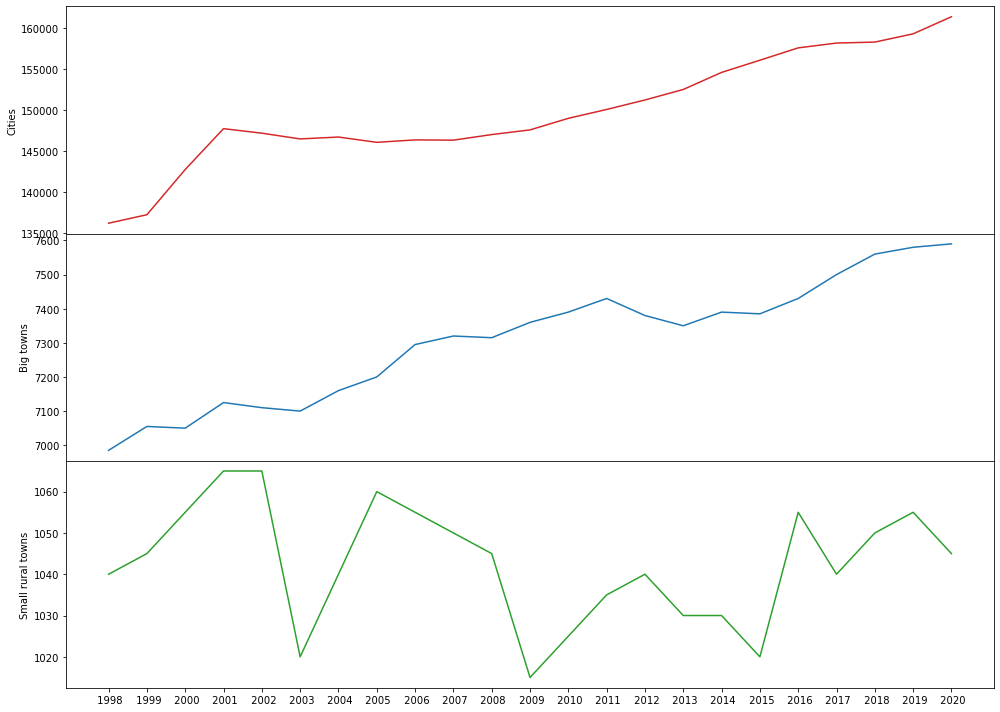

In [66]:
years = MedianPop9820_df['Year']
SRT_median= MedianPop9820_df['small_rural_town_pop_median']
#ST_median= MedianPop9820_df['small_town_pop_median']
BT_median = MedianPop9820_df['big_town_pop_median']
city_median= MedianPop9820_df['city_pop_median']

fig, axs = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0})
#fig.title('Population 1999-2020')
axs[0].plot(years, city_median, color='tab:red')
axs[1].plot(years, BT_median, color='tab:blue')
#axs[2].plot(years, ST_median, color='tab:orange')
axs[2].plot(years, SRT_median, color='tab:green')

# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()

axs[0].set(ylabel='Cities')
axs[1].set(ylabel='Big towns')
#axs[2].set(ylabel='Small towns')
axs[2].set(ylabel='Small rural towns')
    
fig.set_size_inches(14, 10)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.xticks(np.arange(int(years.values[0].strip()), int(years.values[-1].strip())+1, 5))
plt.show()

In [39]:
MeanPop9820_df = Population_9820_df.groupby(['Designation'], as_index=True).agg({
                                                        ' 1998':'mean',
                                                        ' 1999':'mean',
                                                        ' 2000':'mean',
                                                        ' 2001':'mean',
                                                        ' 2002':'mean',
                                                        ' 2003':'mean',
                                                        ' 2004':'mean',
                                                        ' 2005':'mean',
                                                        ' 2006':'mean',
                                                        ' 2007':'mean',
                                                        ' 2008':'mean',
                                                        ' 2009':'mean',
                                                        ' 2010':'mean',
                                                        ' 2011':'mean',
                                                        ' 2012':'mean',
                                                        ' 2013':'mean',
                                                        ' 2014':'mean',
                                                        ' 2015':'mean',
                                                        ' 2016':'mean',
                                                        ' 2017':'mean',
                                                        ' 2018':'mean',
                                                        ' 2019':'mean',
                                                        ' 2020':'mean',})
MeanPop9820_df=MeanPop9820_df.transpose()
MeanPop9820_df.rename(columns={'Designation':'Year','big_town':'big_town_pop_mean','city':'city_pop_mean','rural_area':'rural_area_pop_mean',
                                'small_rural_town':'small_rural_town_pop_mean','small_town':'small_town_pop_mean'}, inplace=True)
MeanPop9820_df.reset_index(inplace=True)
MeanPop9820_df.rename(columns={'index':'Year'}, inplace=True)
MeanPop9820_df.drop(['empty'], axis=1, inplace=True)
MeanPop9820_df.head()

Designation,Year,big_town_pop_mean,city_pop_mean,rural_area_pop_mean,small_rural_town_pop_mean,small_town_pop_mean
0,1998,12578.536122,199951.666667,162.201946,1200.963855,1225.801020
1,1999,12656.026616,201970.238095,161.472019,1204.799197,1227.357143
2,2000,12742.503169,203406.666667,161.873479,1208.835341,1233.719388
3,2001,12843.745247,204814.285714,162.627737,1213.232932,1240.459184
4,2002,12939.866920,206872.619048,164.306569,1217.630522,1245.346939


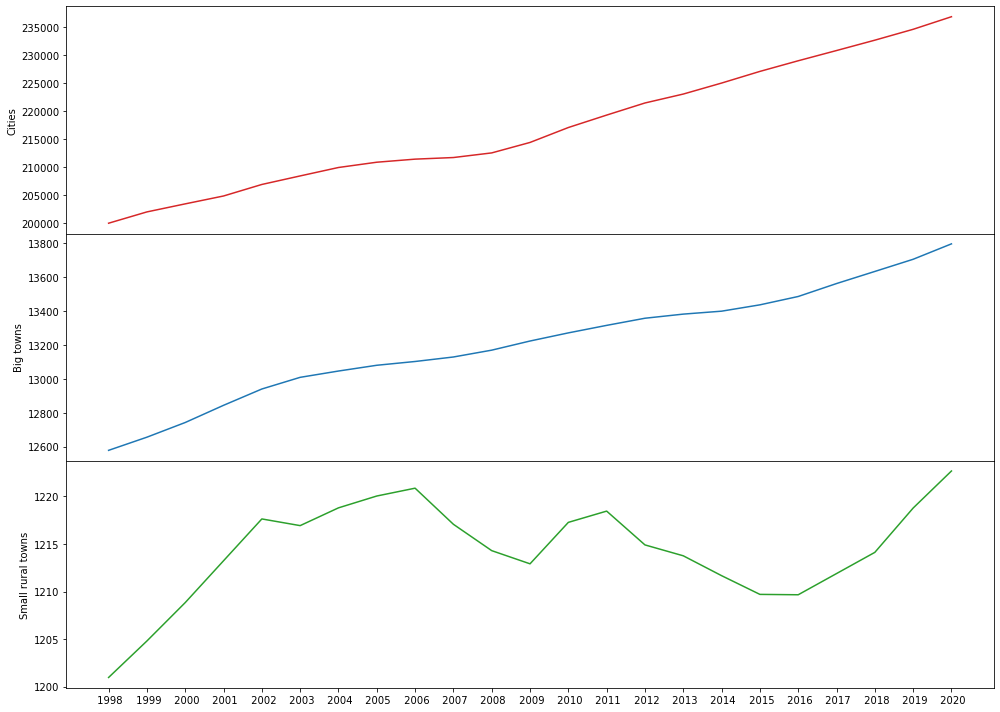

In [67]:
years = MeanPop9820_df['Year']
SRT_mean= MeanPop9820_df['small_rural_town_pop_mean']
#ST_mean= MeanPop9820_df['small_town_pop_mean']
BT_mean = MeanPop9820_df['big_town_pop_mean']
city_mean= MeanPop9820_df['city_pop_mean']

fig, axs = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0})
#fig.title('Population 1999-2020')
axs[0].plot(years, city_mean, color='tab:red')
axs[1].plot(years, BT_mean, color='tab:blue')
#axs[2].plot(years, ST_mean, color='tab:orange')
axs[2].plot(years, SRT_mean, color='tab:green')

# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()

axs[0].set(ylabel='Cities')
axs[1].set(ylabel='Big towns')
#axs[2].set(ylabel='Small towns')
axs[2].set(ylabel='Small rural towns')
    
fig.set_size_inches(14, 10)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [51]:
MedianGrowth_df = Growth_df.groupby(['Designation'], as_index=True).agg({
                                                        ' 1999':'median',
                                                        ' 2000':'median',
                                                        ' 2001':'median',
                                                        ' 2002':'median',
                                                        ' 2003':'median',
                                                        ' 2004':'median',
                                                        ' 2005':'median',
                                                        ' 2006':'median',
                                                        ' 2007':'median',
                                                        ' 2008':'median',
                                                        ' 2009':'median',
                                                        ' 2010':'median',
                                                        ' 2011':'median',
                                                        ' 2012':'median',
                                                        ' 2013':'median',
                                                        ' 2014':'median',
                                                        ' 2015':'median',
                                                        ' 2016':'median',
                                                        ' 2017':'median',
                                                        ' 2018':'median',
                                                        ' 2019':'median',
                                                        ' 2020':'median'})
MedianGrowth_df = MedianGrowth_df.transpose()
MedianGrowth_df.rename(columns={'Designation':'Year'}, inplace=True)
MedianGrowth_df.reset_index(inplace=True)
MedianGrowth_df.rename(columns={'index':'Year'}, inplace=True)
MedianGrowth_df.drop(['empty'], axis=1, inplace=True)
MedianGrowth_df.head(20)

Designation,Year,big_town,city,rural_area,small_rural_town,small_town
0,1999,0.255319,0.786568,0.0,0.000000,0.000000
1,2000,0.390286,0.583757,0.0,0.000000,0.228058
2,2001,0.410742,0.498925,0.0,0.000000,0.405681
3,2002,0.400687,0.675069,0.0,0.000000,0.000000
4,2003,0.184672,0.683010,0.0,0.000000,0.000000
5,2004,0.068658,0.841368,0.0,0.000000,0.000000
6,2005,0.068540,0.467488,0.0,0.000000,0.000000
7,2006,-0.039143,0.452297,0.0,0.000000,0.000000
8,2007,0.000000,0.179192,0.0,-0.386106,-0.218115
9,2008,0.062247,0.394898,0.0,-0.263160,0.000000


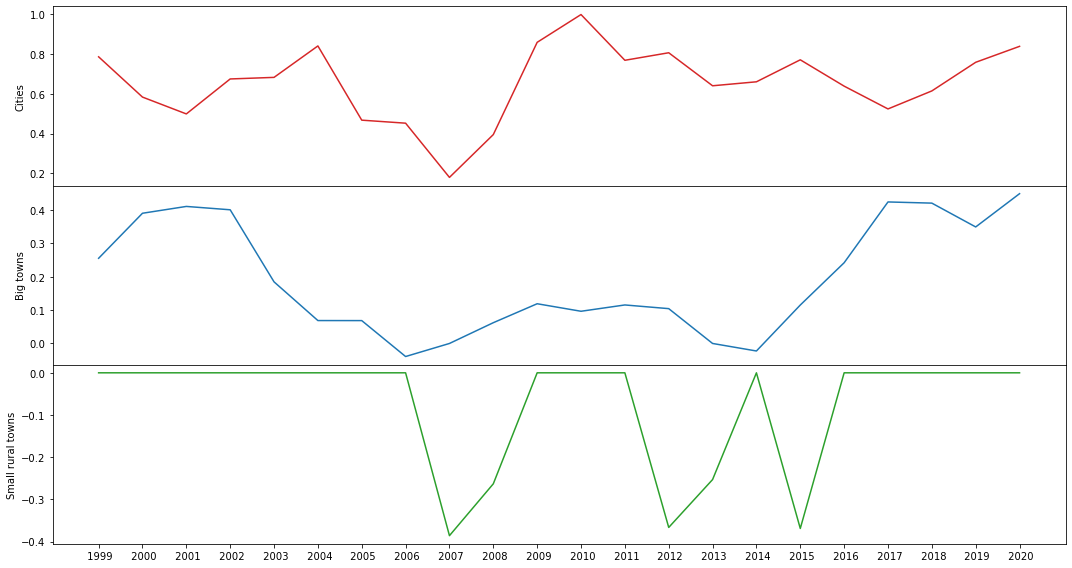

In [47]:
years = MedianGrowth_df['Year']
SRT_median= MedianGrowth_df['small_rural_town']
#ST_median= MedianPop9820_df['small_town_pop_median']
BT_median = MedianGrowth_df['big_town']
city_median= MedianGrowth_df['city']

fig, axs = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0})
#fig.title('Population 1999-2020')
axs[0].plot(years, city_median, color='tab:red')
axs[1].plot(years, BT_median, color='tab:blue')
#axs[2].plot(years, ST_median, color='tab:orange')
axs[2].plot(years, SRT_median, color='tab:green')

# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()

axs[0].set(ylabel='Cities')
axs[1].set(ylabel='Big towns')
#axs[2].set(ylabel='Small towns')
axs[2].set(ylabel='Small rural towns')
    
fig.set_size_inches(15, 8)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [50]:
MeanGrowth_df = Growth_df.groupby(['Designation'], as_index=True).agg({
                                                        ' 1999':'mean',
                                                        ' 2000':'mean',
                                                        ' 2001':'mean',
                                                        ' 2002':'mean',
                                                        ' 2003':'mean',
                                                        ' 2004':'mean',
                                                        ' 2005':'mean',
                                                        ' 2006':'mean',
                                                        ' 2007':'mean',
                                                        ' 2008':'mean',
                                                        ' 2009':'mean',
                                                        ' 2010':'mean',
                                                        ' 2011':'mean',
                                                        ' 2012':'mean',
                                                        ' 2013':'mean',
                                                        ' 2014':'mean',
                                                        ' 2015':'mean',
                                                        ' 2016':'mean',
                                                        ' 2017':'mean',
                                                        ' 2018':'mean',
                                                        ' 2019':'mean',
                                                        ' 2020':'mean',})
MeanGrowth_df = MeanGrowth_df.transpose()
MeanGrowth_df.rename(columns={'Designation':'Year'}, inplace=True)
MeanGrowth_df.reset_index(inplace=True)
MeanGrowth_df.rename(columns={'index':'Year'}, inplace=True)
MeanGrowth_df.drop(['empty'], axis=1, inplace=True)
MeanGrowth_df.head(20)

Designation,Year,big_town,city,rural_area,small_rural_town,small_town
0,1999,0.621476,1.251195,inf,0.278158,0.211299
1,2000,0.672963,0.902238,inf,0.441829,0.597286
2,2001,0.781407,0.822789,inf,0.386840,0.709582
3,2002,0.724403,0.981089,inf,0.332385,0.426093
4,2003,0.456873,0.816579,-0.130791,0.146207,0.218385
5,2004,0.238623,0.812250,inf,0.129844,1.158744
6,2005,0.246752,0.492485,inf,0.399215,0.093372
7,2006,0.155327,0.407525,-1.394674,0.095646,0.021162
8,2007,0.198020,0.276558,inf,-0.327213,inf
9,2008,0.236758,0.388721,inf,-0.154395,inf


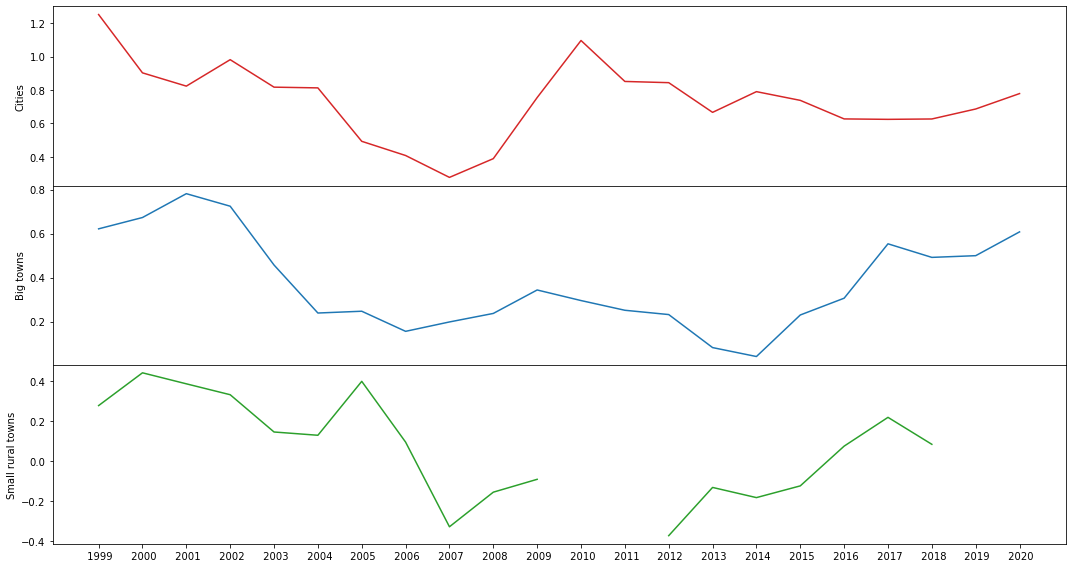

In [49]:
years = MeanGrowth_df['Year']
SRT_mean= MeanGrowth_df['small_rural_town']
#ST_median= MedianPop9820_df['small_town_pop_median']
BT_mean = MeanGrowth_df['big_town']
city_mean= MeanGrowth_df['city']

fig, axs = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0})
#fig.title('Population 1999-2020')
axs[0].plot(years, city_mean, color='tab:red')
axs[1].plot(years, BT_mean, color='tab:blue')
#axs[2].plot(years, ST_median, color='tab:orange')
axs[2].plot(years, SRT_mean, color='tab:green')

# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()

axs[0].set(ylabel='Cities')
axs[1].set(ylabel='Big towns')
#axs[2].set(ylabel='Small towns')
axs[2].set(ylabel='Small rural towns')
    
fig.set_size_inches(15, 8)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Compare Average incomes: Table 84286NED

In [70]:
# The code was removed by Watson Studio for sharing.

,Wijken en buurten,Regioaanduiding/Gemeentenaam (naam),Regioaanduiding/Soort regio (omschrijving),Regioaanduiding/Codering (code),Regioaanduiding/Indelingswijziging wijken en buurten (code),Inkomen/Inkomen van personen/Gemiddeld inkomen per inwoner (x 1 000 euro),Postcode/Meest voorkomende postcode (code)
0,Aa en Hunze,Aa en Hunze,Gemeente,GM1680,.,"26,3",.
1,Wijk 00 Annen,Aa en Hunze,Wijk,WK168000,1,"27,5",.
2,Annen,Aa en Hunze,Buurt,BU16800000,1,"26,7",9468
3,Verspreide huizen Annen,Aa en Hunze,Buurt,BU16800009,1,"45,6",9468
4,Wijk 01 Eext,Aa en Hunze,Wijk,WK168001,1,"25,5",.


In [104]:
df_dat5=df_data5.drop(['Wijken en buurten','Regioaanduiding/Gemeentenaam (naam)','Regioaanduiding/Codering (code)','Regioaanduiding/Indelingswijziging wijken en buurten (code)'],
                     axis=1)
df_dat5.columns=['Region type','Avg Income(x1000)','4_digit_Postalcode']
df_dat5 = df_dat5.loc[df_dat5['Region type'].str.match('Buurt')]
df_dat5 = df_dat5.drop(['Region type'], axis=1)
df_dat5.shape

(13305, 2)

In [111]:
df_dat5['4_digit_Postalcode'] = df_dat5['4_digit_Postalcode'].replace('         .', np.nan)
df_dat5 = df_dat5.dropna()
df_dat5.reset_index(drop=True, inplace=True)
df_dat6=df_dat5.astype({'4_digit_Postalcode': 'int64'})
df_dat6.head()

,Avg Income(x1000),4_digit_Postalcode
0,"26,7",9468
1,"45,6",9468
2,"24,8",9463
3,"30,8",9463
4,"28,6",9467


In [112]:
df_dat6.dtypes

Avg Income(x1000)     object
4_digit_Postalcode     int64
dtype: object

We have now filtered all the average incomes on a 4-digit-Postalcode basis. I will now merge this with PC4_df, which links postalcodes to place names. By grouping on place, while aggregating income as average, I will get the average income for each place.

In [131]:
#Read PC4_df table into dataframe
query = 'SELECT  "4_digit_Postalcode","Place_code", "Place_name",  "Municipality", "Province" FROM "VSR62892"."PostalCodes_vs_Places";'
PC4_df = pd.read_sql_query(query, engine)
PC4_df.dtypes

4_digit_Postalcode     int64
Place_code            object
Place_name            object
Municipality          object
Province              object
dtype: object

In [132]:
df_dat7= pd.merge(df_dat6, PC4_df, how='inner', on='4_digit_Postalcode')

In [133]:
df_dat7.head()

,Avg Income(x1000),4_digit_Postalcode,Place_code,Place_name,Municipality,Province
0,"26,7",9468,1150,Annen,Aa en Hunze,Drenthe
1,"45,6",9468,1150,Annen,Aa en Hunze,Drenthe
2,"24,8",9463,1155,Eext,Aa en Hunze,Drenthe
3,"30,8",9463,1155,Eext,Aa en Hunze,Drenthe
4,"28,6",9467,1149,Anloo,Aa en Hunze,Drenthe


In [134]:
income_lst =[]

for income in df_dat7['Avg Income(x1000)']:
    income_cln = income.strip().replace(',','.')
    income_lst.append({"Avg Income(x1000)": float(income_cln)})

income_df=pd.DataFrame(income_lst)
income_df.head()

,Avg Income(x1000)
0,26.7
1,45.6
2,24.8
3,30.8
4,28.6


In [135]:
df_dat7['Avg_Income (x1000)']= income_df['Avg Income(x1000)']
#df_dat7.drop([''], axis=1, inplace=True)
df_dat7.head()

,Avg Income(x1000),4_digit_Postalcode,Place_code,Place_name,Municipality,Province,Avg_Income (x1000)
0,"26,7",9468,1150,Annen,Aa en Hunze,Drenthe,26.7
1,"45,6",9468,1150,Annen,Aa en Hunze,Drenthe,45.6
2,"24,8",9463,1155,Eext,Aa en Hunze,Drenthe,24.8
3,"30,8",9463,1155,Eext,Aa en Hunze,Drenthe,30.8
4,"28,6",9467,1149,Anloo,Aa en Hunze,Drenthe,28.6


In [136]:
AvgIncome_df = df_dat7.groupby(['Place_code','Place_name','Municipality','Province'], as_index=False).agg({'Avg_Income (x1000)':'mean'})
AvgIncome_df.rename(columns={'Place_code':'Plc_code'}, inplace=True)
AvgIncome_df.head()

,Plc_code,Place_name,Municipality,Province,Avg_Income (x1000)
0,1000,Hoogerheide,Woensdrecht,Noord-Brabant,24.333333
1,1001,Huijbergen,Woensdrecht,Noord-Brabant,29.033333
2,1002,Ossendrecht,Woensdrecht,Noord-Brabant,29.000000
3,1003,Putte,Woensdrecht,Noord-Brabant,25.250000
4,1004,Woensdrecht,Woensdrecht,Noord-Brabant,26.400000


In [137]:
#Recall the designation list from db2
query = 'SELECT "Plc_code", "Designation" FROM "VSR62892"."plcCode_vs_Designation";'
Designation_df = pd.read_sql_query(query, engine)
Designation_df.head()

,Plc_code,Designation
0,1925,small_town
1,2774,small_rural_town
2,2145,small_rural_town
3,2571,big_town
4,1600,small_town


In [138]:
#Inner merge with AvgIncome_df:
AvgIncome_df= pd.merge(AvgIncome_df, Designation_df, how='inner', on='Plc_code')

In [139]:
AvgIncome_df.head()

,Plc_code,Place_name,Municipality,Province,Avg_Income (x1000),Designation
0,1000,Hoogerheide,Woensdrecht,Noord-Brabant,24.333333,big_town
1,1001,Huijbergen,Woensdrecht,Noord-Brabant,29.033333,small_town
2,1002,Ossendrecht,Woensdrecht,Noord-Brabant,29.000000,big_town
3,1003,Putte,Woensdrecht,Noord-Brabant,25.250000,big_town
4,1004,Woensdrecht,Woensdrecht,Noord-Brabant,26.400000,small_town


In [140]:
AvgIncome_df.to_sql('AverageIncomes_2018', engine) #Store backup on DB2

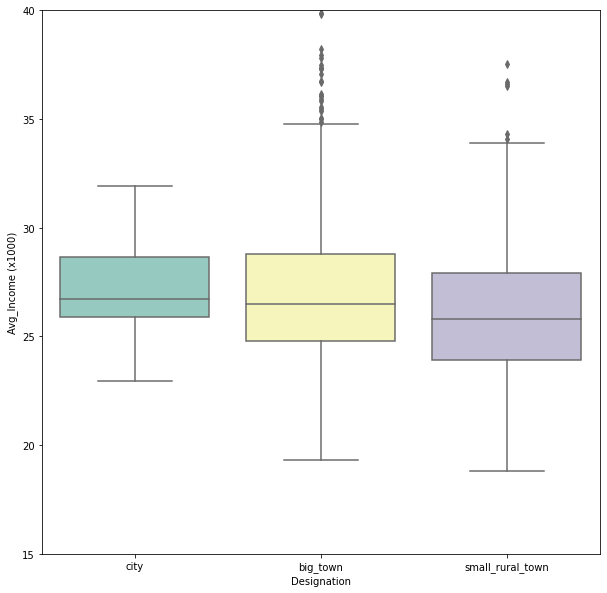

In [145]:
#Get subset out of PlacesNL_df
bxplt_df = AvgIncome_df[['Designation','Avg_Income (x1000)']]
bxplt_df = bxplt_df[(bxplt_df['Designation'] != 'rural_area') & (bxplt_df['Designation'] != 'small_town') & (bxplt_df['Designation'] != 'empty')]
#print(bxplt_df.shape)
#bxplt_df['Designation'].value_counts()

fig, ax1 = plt.subplots()
fig.set_size_inches(10, 10)
sns.boxplot(x=bxplt_df['Designation'], y=bxplt_df['Avg_Income (x1000)'], order=['city','big_town','small_rural_town'], palette='Set3')
ax1.set(ylim=(15, 40))
plt.show()

## 2.2: Comparison between Rural Towns
I will now look at the comparisons, in population growth and average income, and rank them on performance

### 2.2.1: Population growth

In [56]:
#Reload Population Table
query = 'SELECT "Plc_code", "Place_name", "Municipality", "Province", " 1998", " 1999", " 2000", " 2001", " 2002", " 2003", " 2004", " 2005", " 2006", " 2007", " 2008", " 2009", " 2010", " 2011", " 2012", " 2013", " 2014", " 2015", " 2016", " 2017", " 2018", " 2019", " 2020", "Designation" FROM "VSR62892"."plcCode_vs_Populations";'
Population_9820_df = pd.read_sql_query(query, engine)

In [57]:
#Select set of rural towns
SRT_9820_df=Population_9820_df[(Population_9820_df['Designation']=='small_rural_town') & (Population_9820_df[' 1999'] !=0)]

In [58]:
cols=[ ' 1999',' 2000', ' 2001', ' 2002', ' 2003', ' 2004', ' 2005', ' 2006', ' 2007',
       ' 2008', ' 2009', ' 2010', ' 2011', ' 2012', ' 2013', ' 2014', ' 2015',
       ' 2016', ' 2017', ' 2018', ' 2019', 'Designation']
SRT_9820_df.drop(cols, axis=1, inplace=True)
SRT_9820_df.head()

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Plc_code,Place_name,Municipality,Province,1998,2020
16,1017,Foxhol,Midden-Groningen,Groningen,980.0,925.0
24,1027,Broekhuizen,Horst aan de Maas,Limburg,790.0,765.0
25,1028,Broekhuizenvorst,Horst aan de Maas,Limburg,1135.0,1045.0
26,1029,Griendtsveen,Horst aan de Maas,Limburg,540.0,545.0
28,1031,Hegelsom,Horst aan de Maas,Limburg,1815.0,1955.0


Add collum to calculate growth in percentages

In [59]:
#Calculate Population growth between 1998-2020, in percentages. Delete other years.
SRT_9820_df['Growth_1998-2020'] = ((SRT_9820_df[' 2020']-SRT_9820_df[' 1998'])/SRT_9820_df[' 1998'])*100

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [61]:
#Order set to find best and worst towns
Ordered_SRT_9820_df = SRT_9820_df.sort_values('Growth_1998-2020')
Ordered_SRT_9820_df.head()

,Plc_code,Place_name,Municipality,Province,1998,2020,Growth_1998-2020
186,1198,Lekkum,Leeuwarden,Fryslân / Friesland,515.0,405.0,-21.359223
435,1452,Katwijk NB,Cuijk,Noord-Brabant,495.0,395.0,-20.202020
796,1831,Garmerwolde,Groningen,Groningen,600.0,490.0,-18.333333
153,1164,Gasselternijveenschemond,Aa en Hunze,Drenthe,785.0,655.0,-16.560510
1726,2814,Holtum,Sittard-Geleen,Limburg,1375.0,1155.0,-16.000000


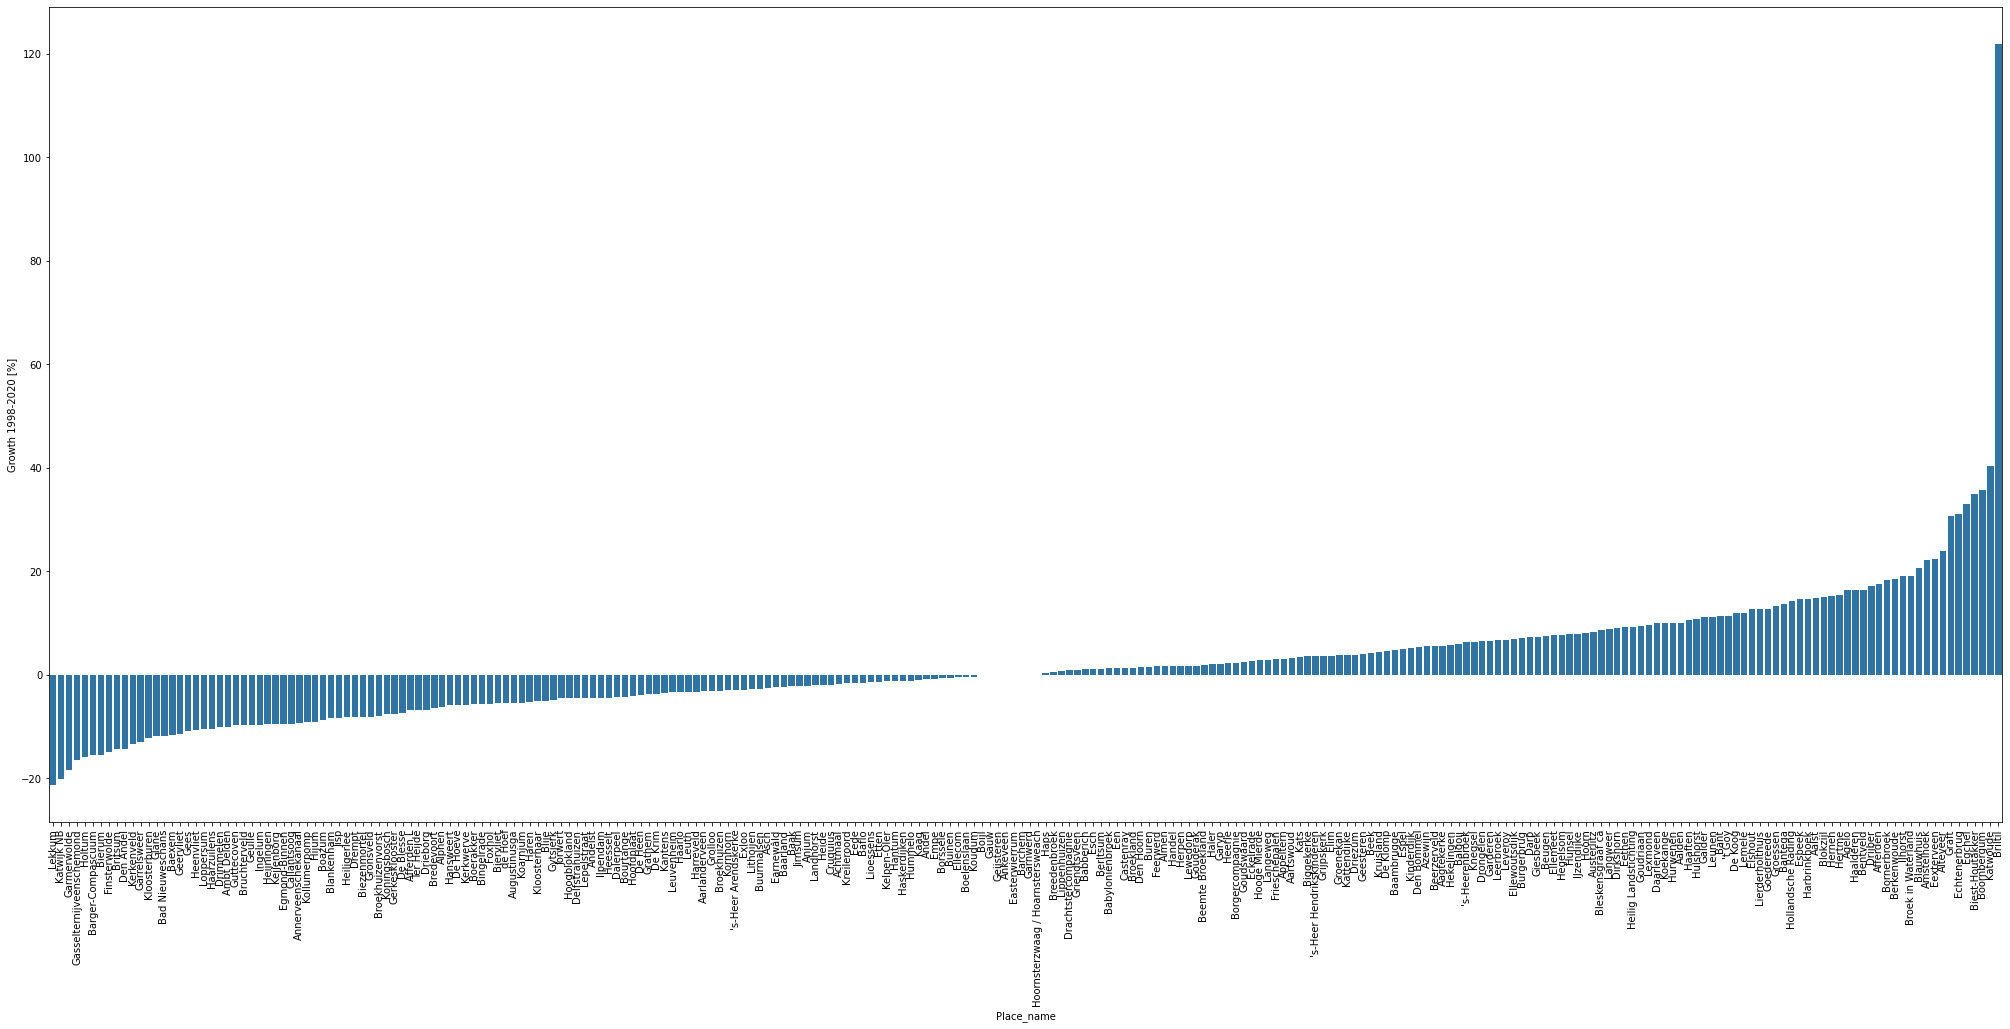

In [63]:
#Get subset out of PlacesNL_df
barplt_df = Ordered_SRT_9820_df[['Place_name','Growth_1998-2020']]
#print(bxplt_df.shape) palette='Set3'
#bxplt_df['Designation'].value_counts()

fig, ax1 = plt.subplots()
fig.set_size_inches(35, 15)
growth_bar=sns.barplot(x=barplt_df['Place_name'], y=barplt_df['Growth_1998-2020'], color='tab:blue')
ax1.set(ylabel='Growth 1998-2020 [%]')
for item in growth_bar.get_xticklabels():
    item.set_rotation(90)
    
#ax1.set(ylim=(-30, 60))
plt.show()

### 2.2.2: Average Income

In [75]:
#Reload Income Table
query = 'SELECT "Plc_code", "Place_name", "Municipality", "Province", "Avg_Income (x1000)", "Designation" FROM "VSR62892"."AverageIncomes_2018";'
AvgIncome_df = pd.read_sql_query(query, engine)
#AvgIncome_df.head()

In [76]:
AverageIncome = AvgIncome_df['Avg_Income (x1000)'].mean()
AverageIncome

26.551825466878437

In [77]:
SRT_AvgIncome_df = AvgIncome_df[(AvgIncome_df['Designation']=='small_rural_town') & (AvgIncome_df['Avg_Income (x1000)'] !=0)]
#SRT_AvgIncome_df.head()

In [78]:
SRT_AvgIncome_df['Relative_Income (x1000)']= SRT_AvgIncome_df['Avg_Income (x1000)'] - AverageIncome
#SRT_AvgIncome_df.head()

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [79]:
SRT_AvgIncome_df.columns

Index(['Plc_code', 'Place_name', 'Municipality', 'Province',
       'Avg_Income (x1000)', 'Designation', 'Relative_Income (x1000)'],
      dtype='object')

In [80]:
cols=['Place_name', 'Municipality', 'Province', 'Designation']
SRT_AI_df =SRT_AvgIncome_df.drop(cols, axis=1)
SRT_AI_df.head()

,Plc_code,Avg_Income (x1000),Relative_Income (x1000)
16,1017,20.30,-6.251825
23,1027,24.55,-2.001825
24,1028,24.25,-2.301825
25,1029,25.00,-1.551825
27,1031,26.00,-0.551825


In [81]:
#Inner SRT_AI_df merge with Ordered_SRT_9820_df
SRT_AI_9820_df = pd.merge(Ordered_SRT_9820_df, SRT_AI_df, how='inner', on='Plc_code')

In [98]:
print(SRT_AI_9820_df.shape)
SRT_AI_9820_df.head()

(245, 9)


,Plc_code,Place_name,Municipality,Province,1998,2020,Growth_1998-2020,Avg_Income (x1000),Relative_Income (x1000)
0,1198,Lekkum,Leeuwarden,Fryslân / Friesland,515.0,405.0,-21.359223,24.1,-2.451825
1,1452,Katwijk NB,Cuijk,Noord-Brabant,495.0,395.0,-20.202020,27.9,1.348175
2,1831,Garmerwolde,Groningen,Groningen,600.0,490.0,-18.333333,28.0,1.448175
3,1164,Gasselternijveenschemond,Aa en Hunze,Drenthe,785.0,655.0,-16.560510,24.3,-2.251825
4,2814,Holtum,Sittard-Geleen,Limburg,1375.0,1155.0,-16.000000,26.3,-0.251825


In [84]:
SRT_AI_9820_df.to_sql('SRT_PopulationGrowth_AvgIncomes2018', engine) #Store backup on DB2

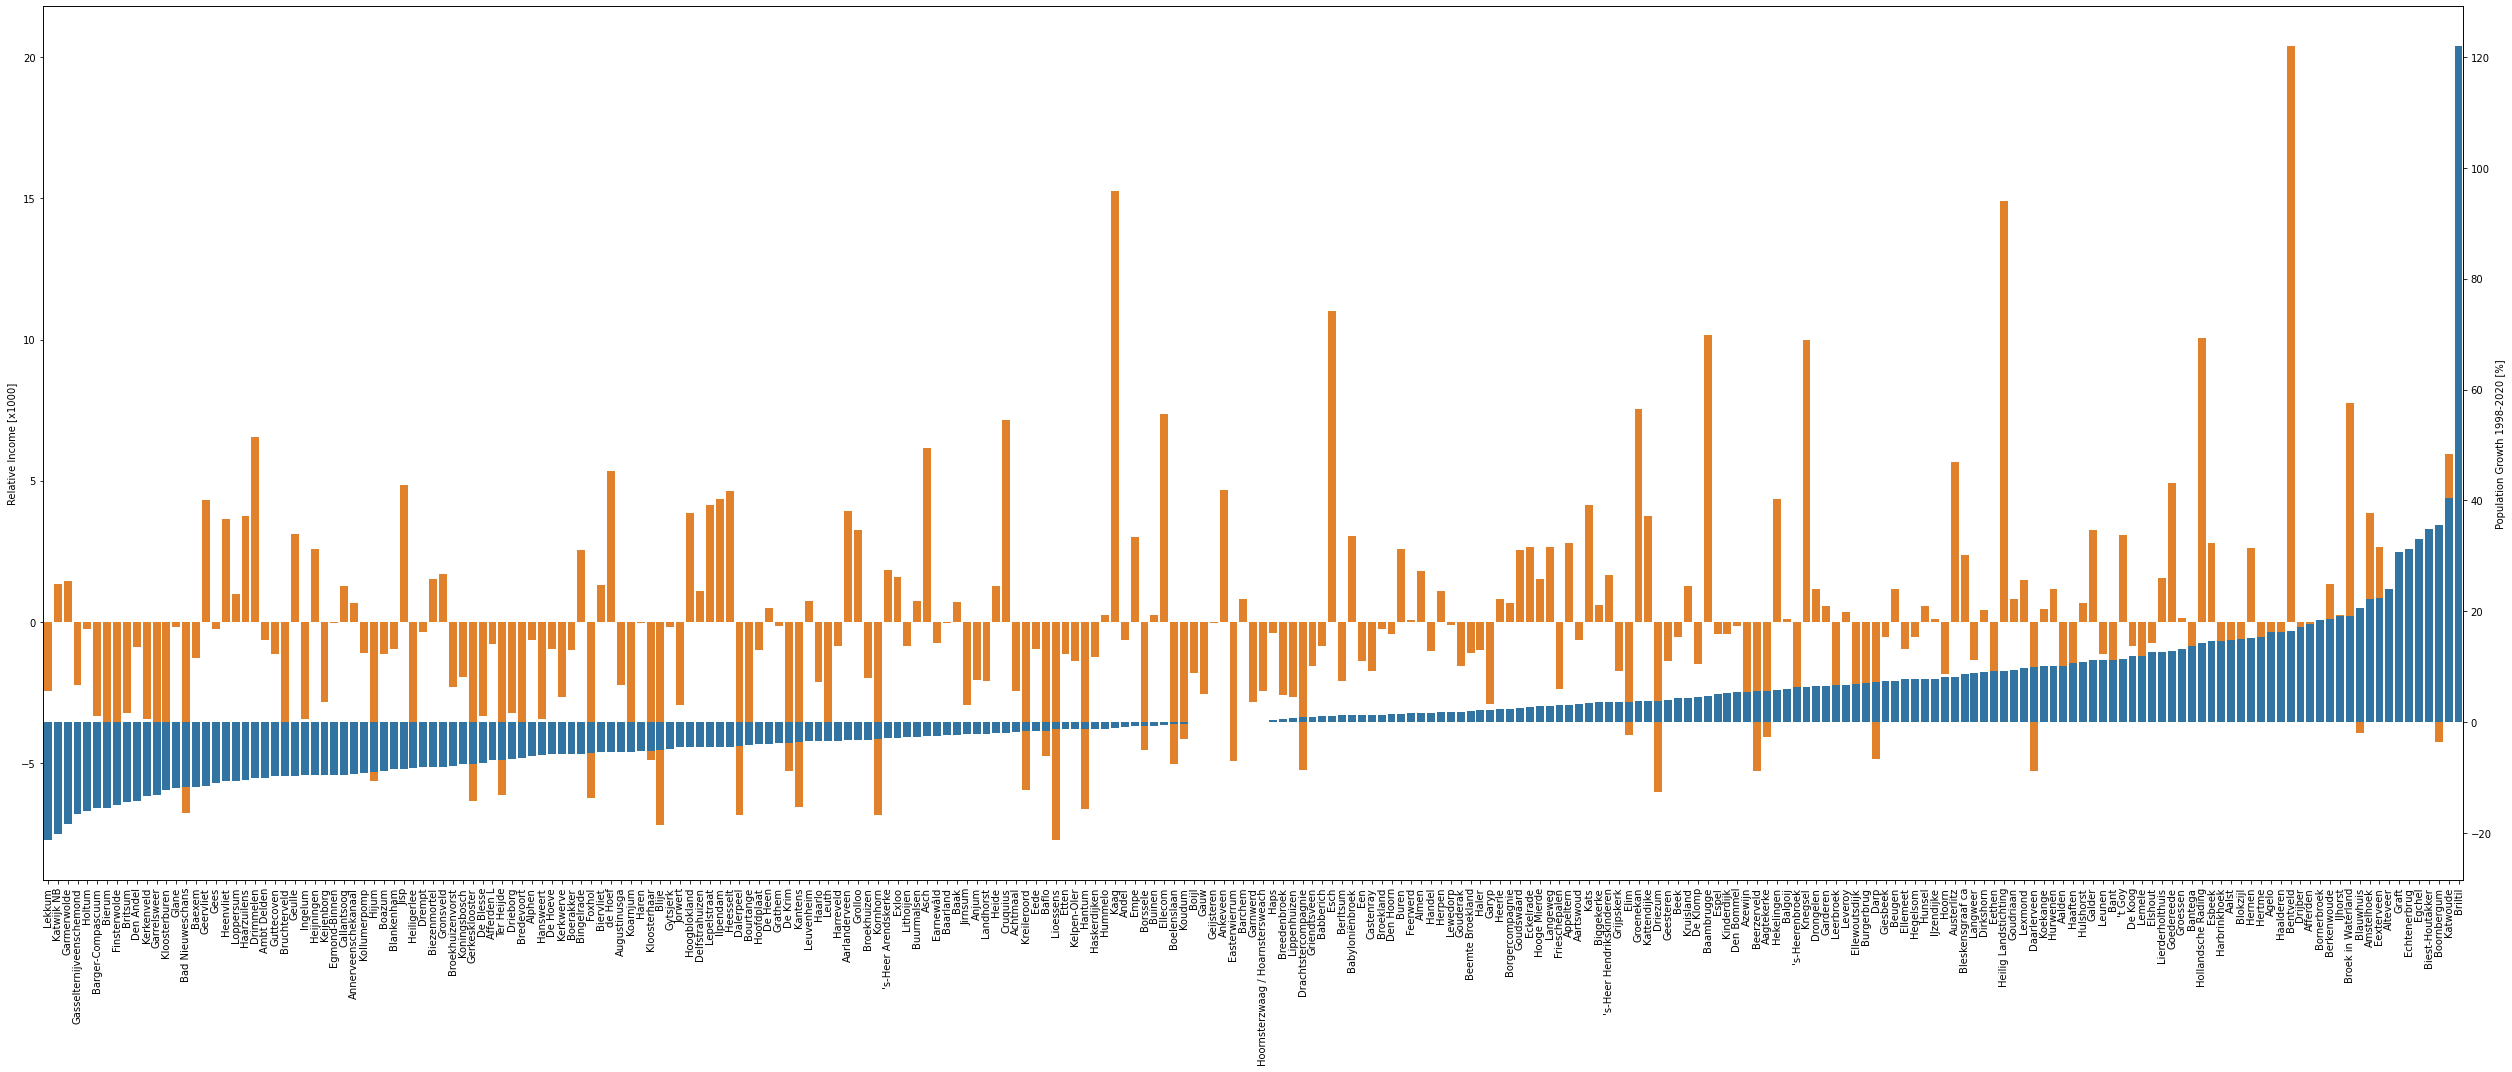

In [108]:
#Get Series in order to plot barchart
x_labels = SRT_AI_9820_df['Place_name']
y_growth = SRT_AI_9820_df['Growth_1998-2020']
y_income = SRT_AI_9820_df['Relative_Income (x1000)']

fig, axs = plt.subplots()
fig.set_size_inches(35, 15)

income_bar=sns.barplot(x=x_labels, y=y_income, color='tab:orange', ax=axs)
axs.set(xlabel='')
axs.set(ylabel='Relative Income [x1000]')

for item in income_bar.get_xticklabels():
    item.set_rotation(90)

ax2 = axs.twinx()  # instantiate a second axes that shares the same x-axis

sns.barplot(x=x_labels, y=y_growth, color='tab:blue', ax=ax2)
ax2.set(ylabel='Population Growth 1998-2020 [%]')

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()